# Optimising Starbuck's rewards program 

# Table of Contents

1. [Introduction](#intro)<br>
    i. [Data Sets](#data)<br>
2. [Data Assessment & Cleaning](#clean)<br>
3. [Exploratory Data Analysis](#eda)<br>
    i. [Customer segmentation](#segmentation)<br>
4. [Data Preprocessing](#preprocessing)<br>
5. [Prediction Modeling](#prediction)<br>
   [Gradient Boosting Classifier](#gb)<br>
   [Tuning Parameter Refinement](#tune)<br>
6. [Conclusion](#conclusion)<br>
    i. [Results](#results)<br>
    ii. [Recommendations](#recs)<br>

<a id='intro'></a>
# 1. Introduction

Starbucks is one of the largest coffehouses in the world. They have been known for having done of the most vigorous digitalisaion strategies that has seen them grow to become titans in industry. In the first quarter of 2020, it witnessed a 16pc in year over year growth recording 18.9 million active users. It is infamous for its rewards program. According to starbucks, as of end of 2020, nearly a quarter of their transactions are done through the phone. This means that, a substantial amount of its revenue relies on the rewards app. In this project, we seek to analyse customer behavior of the starbucks rewards app so we can optimise profits by targetted marketing.

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer.

The objective is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. 

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Starbuks has provided transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

The "transaction" event does not have any "offer_id" associated to it, so we have to figure out which transactions are connected to particular offer and which ones are not (customer bought something casually).

Informational offer can not be "completed" due to it's nature, so we need to find a way to connect it with the possible transactions.

Some demographic groups will make purchases regardless of whether they receive an offer. Ideally we would like to group them separately.

A user can complete the offer without actually seeing it. In this case user was making a regular purchase and offer completed automatically. This is not a result of particular marketing campaign but rather a coincidence.

<a id='data'> </a>
# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Data quality issues**:
* Null values for "gender" and "income" in profile.json
* Age: missing value encoded as 118 in profile.json
* Incorrect data format (int64 instead of datetime) in profile.json
* Column names can be improved
* Incompatible units - offer duration days vs. event time in hours
* Different keys in transcript.json - "event id" and "event_id"


### Implementation Steps:
* Data exploration
* Data cleaning
* Exploratory data analysis (EDA)
* Customer segmentation
* Exploring the resultant clusters
* Data Preprocessing
* Training the model
* Improving the model
* Choosing the best performing model
* Deploying the best model
* Exploring the prediction results


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes.utils import summary_data_from_transaction_data
import datetime

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import recall_score


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import sklearn.model_selection

from yellowbrick.cluster.elbow import kelbow_visualizer

### Read in the dataset

In [2]:
# read in the json files
portfolio = pd.read_json('./portfolio.json', orient='records', lines=True)
profile = pd.read_json('./profile.json', orient='records', lines=True)
transcript = pd.read_json('./transcript.json', orient='records', lines=True)

<a id='clean'> </a>
## 2. Data Assesment and cleaning

### Portfolio data

In [3]:
portfolio.head()[:5]

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


#### Rename the columns to meaningful names

In [4]:
#rename the column to meaningful names
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio.rename(columns={'duration': 'offer_duration_days'}, inplace=True)
portfolio.rename(columns={'difficulty': 'spent_required'}, inplace=True)
portfolio.rename(columns={'reward': 'possible_reward'}, inplace=True)

Check for null values

In [5]:
#check for null values
portfolio.isnull().sum()

possible_reward        0
channels               0
spent_required         0
offer_duration_days    0
offer_type             0
offer_id               0
dtype: int64

There are no missing values. 

#### Extract data from the channels column

In [6]:
# create dummy variables for channels
portfolio_clean = portfolio.copy() 

In [7]:
 # Create dummy columns for the channels column
d_chann = pd.get_dummies(portfolio_clean.channels.apply(pd.Series).stack(),
                             prefix="channel").sum(level=0)   

In [8]:
portfolio_clean = pd.concat([portfolio_clean, d_chann], axis=1, sort=False)  

In [9]:
portfolio_clean.drop(columns='channels', inplace=True) 

In [10]:
portfolio_clean

,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


We will use the data for modelling, so we save a copy of the portfolio dataframe here

In [11]:
portfolio_for_modelling=portfolio_clean.copy()

There are 10 offers distinguished by offer_ids, in 3 categories bogo, discount and informational

In [12]:
portfolio_clean[['offer_type','offer_id']]

,offer_type,offer_id
0,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,informational,3f207df678b143eea3cee63160fa8bed
3,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,discount,fafdcd668e3743c1bb461111dcafc2a4
7,informational,5a8bc65990b245e5a138643cd4eb9837
8,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,discount,2906b810c7d4411798c6938adc9daaa5


We will also merge some dataframe for some analysis, so we save this data here

In [13]:
portfolio_fr_df2=portfolio_clean.copy()

Encode the offer types 

In [14]:
portfolio_clean.loc[portfolio_clean['offer_type'] == 'bogo', 'offer_type'] = 1
portfolio_clean.loc[portfolio_clean['offer_type'] == 'discount', 'offer_type'] = 2
portfolio_clean.loc[portfolio_clean['offer_type'] == 'informational', 'offer_type'] = 3

### Profile data

In [15]:
profile = pd.read_json('./profile.json', orient='records', lines=True)

In [16]:
profile[:5]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [17]:
profile.shape

(17000, 5)

Check for null values

In [18]:
profile.isnull().sum()[profile.isnull().sum()>0]

gender    2175
income    2175
dtype: int64

Display the customer profile distribution for age,income and gender

In [19]:
def plot_hist(data, title, xlabel, ylabel, bins=20):
    """Plot a histogram with values passed as input."""
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [20]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    plot_hist(data=profile['age'], title='Customer Age Distrbution', xlabel='Age', ylabel='Count', bins=20)

    # Display Histogram of Customer Income
    plot_hist(data=profile['income'], title='Customer Income Distrbution', xlabel='Income', ylabel='Count', bins=20)
    sns.countplot(profile['gender'])

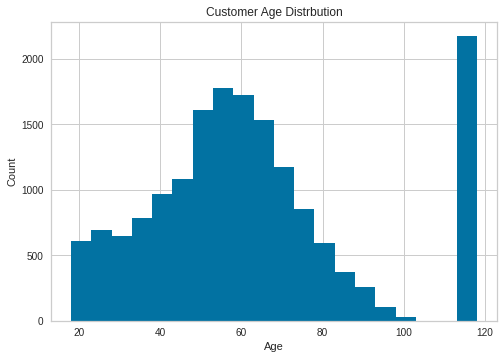

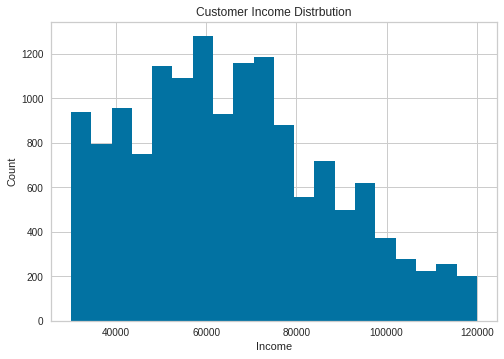

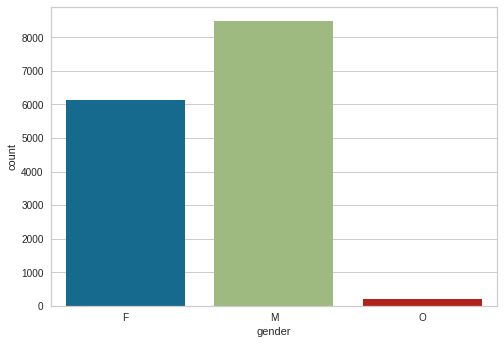

In [21]:
display_customer_profile()

The customer age distribution has some outliers, ages 100-118. It is improbable that starbucks would have app users this age. Income is left skewed, most people earn between 40k and 80k. Gender distribution has males highest followed by females and a few O

In [22]:
profile[profile.age==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [23]:
profile=profile.drop(profile[profile['gender'].isnull()].index)

There are 2175 customers with age 118. Obviously this cant be true. But given that this data was taken in 2018, 2018-118 is 1900 which was probably the default date on the app. 2175 is 12% of our data, dropping these from our analysis and modelling would greatly affect the model since these users made transactions and participated in the experiment. 

Replace values with age 118 with nan values

In [24]:
profile.age.replace(118, np.nan, inplace=True)

Check the datatypes in the profiles data

In [25]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

Change the became_member_on from int to datetime

In [26]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['year'] = profile['became_member_on'].dt.year
profile['quarter'] = profile['became_member_on'].dt.quarter

Rename column name into meaningful name

In [27]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [28]:
profile[:5]

,gender,age,customer_id,became_member_on,income,year,quarter
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,2
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,2
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,4


#### Create new column "days_of_membership"

Create a new column days of membership to calculate how long someone has been a member. Maybe that will have an effect as well into how they spend and how they respond to offers. To do this, we need to know when this data was collected. This we dont have bu we can make an assumption. The last date on this dataset will be used and this is - October 18, 2018. 

In [29]:
import datetime

data_collection_date = "2018-10-18"

profile['days_of_membership'] = datetime.datetime.strptime(data_collection_date, '%Y-%m-%d') - profile['became_member_on']
profile['days_of_membership'] = profile['days_of_membership'].dt.days.astype('int16')

In [30]:
profile[:5]

,gender,age,customer_id,became_member_on,income,year,quarter,days_of_membership
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,3,460
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,2,527
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,2,175
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,1,251
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,4,341


Save the profile data for modelling later

In [31]:
profile_for_modelling=profile.copy()

#### Create an age range column

From the age distribution we saw above, we can group into these categories

<AxesSubplot:>

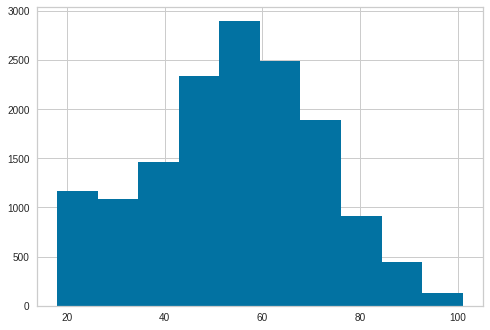

In [32]:
profile['age'].hist()

Create bins for teen, young adult, adult and elderly. 17-22 teen, 22-35 young adult, 35-60 adult, 60-103 elderly

In [33]:

profile['age_group']=pd.cut(profile['age'],bins=[17,22,35,60,103],labels=['teenager','young-adult','adult','elderly'])

In [34]:
x=profile['age'].unique()

Create a list of ages as categories so that we encode them

In [35]:
x=profile['age_group'].astype('category').cat.categories.tolist()

Encode age group as 1-4 to represent the age groups

In [36]:
y={"age_group": {k:v for k,v in zip(x,list(range(1,len(x)+1)))}}

Replace the categories with encoded values

In [37]:
profile.replace(y,inplace=True)

Drop the age column 

In [38]:
profile.drop(columns="age",inplace=True)

#### Create a new income range column

Find the income distribution to come up with bins

In [39]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

From the distribution we see that the min is 30k and the max is 120k, the average is 65k with a standard deviation of 20k

Create new column income range

In [40]:
profile['income_range']=pd.cut(profile['income'],bins=[0,30000,50001,70001,90001,120001],labels=['low','low_to_mid','mid','mid_to_high','high'])

In [41]:
profile['income_range'].value_counts()

mid            5006
low_to_mid     3946
mid_to_high    3591
high           2194
low              88
Name: income_range, dtype: int64

In [42]:
profile[:5]

,gender,customer_id,became_member_on,income,year,quarter,days_of_membership,age_group,income_range
1,F,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,3,460,3,high
3,F,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,2,527,4,high
5,M,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,2,175,4,mid
8,M,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,1,251,4,mid
12,M,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,4,341,3,mid


Encode the income categories

In [43]:
labels=profile['income_range'].astype('category').cat.categories.tolist()

In [44]:
b={'income_range':{k:v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [45]:
profile.replace(b,inplace=True)

Drop the income column since we have the income range

In [46]:
profile.drop(columns="income",inplace=True)

#### Create a loyalty column based on membership

We also want to be able to categorise members as new, regular and or loyal, to aid our analysis

Let's check days of membership distribution

In [47]:
profile['days_of_membership'].describe()

count    14825.000000
mean       606.478988
std        419.205158
min         84.000000
25%        292.000000
50%        442.000000
75%        881.000000
max       1907.000000
Name: days_of_membership, dtype: float64

<AxesSubplot:>

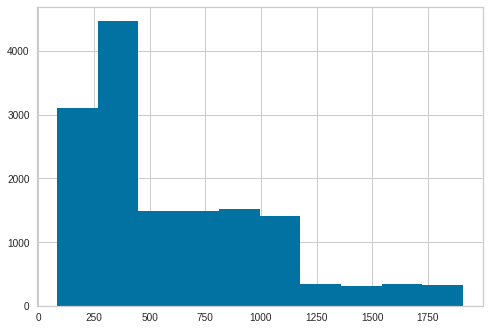

In [48]:
profile['days_of_membership'].hist()

Create bins for the different member types as new, regular and loyal for days of membership between 85 (the minimum) and 1908 (the maximum)

In [49]:
profile['member_type']=pd.cut(profile['days_of_membership'],bins=[84,650,1200,1908],labels=['new','regular','loyal'])

In [50]:
profile['member_type'].value_counts()

new        9215
regular    4293
loyal      1296
Name: member_type, dtype: int64

Encode the member types as categorical variables

In [51]:
x=profile['member_type'].astype('category').cat.categories.tolist()

In [52]:
y={'member_type':{k:v for k,v in zip(x,list(range(1,len(x)+1)))}}


In [53]:
profile.replace(y,inplace=True)

In [54]:
profile[:5]

,gender,customer_id,became_member_on,year,quarter,days_of_membership,age_group,income_range,member_type
1,F,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,3,460,3,5,1.0
3,F,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,2017,2,527,4,5,1.0
5,M,e2127556f4f64592b11af22de27a7932,2018-04-26,2018,2,175,4,3,1.0
8,M,389bc3fa690240e798340f5a15918d5c,2018-02-09,2018,1,251,4,3,1.0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,2017,4,341,3,3,1.0


Drop the days of membership and when customer became a member since we membership type

In [55]:
profile.drop(columns=['days_of_membership','became_member_on'],inplace=True)

In [56]:
profile[:5]

,gender,customer_id,year,quarter,age_group,income_range,member_type
1,F,0610b486422d4921ae7d2bf64640c50b,2017,3,3,5,1.0
3,F,78afa995795e4d85b5d9ceeca43f5fef,2017,2,4,5,1.0
5,M,e2127556f4f64592b11af22de27a7932,2018,2,4,3,1.0
8,M,389bc3fa690240e798340f5a15918d5c,2018,1,4,3,1.0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,2017,4,3,3,1.0


 Check for duplicates

In [57]:
profile.duplicated().sum()

0

Save the profile data for exploratory analysis

In [58]:
profile_fr_df2=profile.copy()

### Transcript data

In [59]:
transcript[:5]

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [60]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [61]:
transcript.shape

(306534, 4)

Split the value column into columns, this method takes time for a large dataset

In [62]:
%%time


cleaned_transcript=pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)

CPU times: user 2min 25s, sys: 2.52 s, total: 2min 28s
Wall time: 2min 30s


In [63]:
cleaned_transcript[:5]

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


We have two columns offer_id, Assign values of offer id column to offer_id column to remove duplicate columns

In [64]:
cleaned_transcript['offer_id'] = cleaned_transcript['offer_id'].fillna(cleaned_transcript['offer id'])

In [65]:
cleaned_transcript.drop(['offer id'], axis=1, inplace=True)

Rename the columns to something more meaningful

In [66]:
cleaned_transcript.rename(columns={'person': 'customer_id'}, inplace=True)
cleaned_transcript.rename(columns={'amount': 'money_spent'}, inplace=True)
cleaned_transcript.rename(columns={'reward': 'money_gained'}, inplace=True)

Offer amount and reward with null values will be assigned as zeros

In [67]:
cleaned_transcript['money_spent'] = cleaned_transcript['money_spent'].replace(np.nan, 0)
cleaned_transcript['money_gained'] = cleaned_transcript['money_gained'].replace(np.nan, 0)

Change time column from hours to days

In [68]:
cleaned_transcript['time'] = cleaned_transcript['time']/24.0

In [69]:
cleaned_transcript[:5]

,customer_id,event,time,money_spent,offer_id,money_gained
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


We only want to analyze the customers whose profile we have so we have to drop customers who have transaction data but do not have profile data.

In [70]:
# Drop customers ids that not available in the profile dataset, because we know nothing about them
cleaned_transcript = cleaned_transcript[cleaned_transcript['customer_id'].isin(profile['customer_id'])]

 One-hot encode events 

In [71]:
transcript_dummies = pd.get_dummies(cleaned_transcript.event)
cleaned_transcript = pd.concat([cleaned_transcript, transcript_dummies], axis=1)

Creating a copy  for some exploratory analysis

In [72]:
transcript_fr_df2=cleaned_transcript.copy()

Taking a look at the events and time columns, it seems like events are ordered according to how much time and not according to whether the offer received, resulted in offer being completed/transaction done

### Further cleaning on transcript/ transaction data

#### Combine the offer completed and  transanction done into 1 row
We want to be able to know when an offer was completed the transaction was done, so we combine the rows for offer completed and transaction done into one row


In [73]:
%%time

print("Total rows: {}".format(len(cleaned_transcript)))

rows_to_drop = [] 

# Loop over "offer completed" events:
c_df = cleaned_transcript[cleaned_transcript.event == "offer completed"]
print('Total "offer completed" rows: {}'.format(len(c_df)))

for c_index, row in c_df.iterrows():
    
    t_index = c_index-1 # transaction row index
    cleaned_transcript.at[c_index, 'money_spent'] = cleaned_transcript.at[t_index, 'money_spent'] # update "amount"
    cleaned_transcript.at[c_index, 'transaction'] = 1
    rows_to_drop.append(t_index) # we will drop the "transaction" row


print("\nRows to drop: {}".format(len(rows_to_drop)))

cleaned_transcript = cleaned_transcript[~cleaned_transcript.index.isin(rows_to_drop)] # faster alternative to dropping rows one by one inside the loop

print("Rows after job is finished: {}".format(len(cleaned_transcript)))

cleaned_transcript[cleaned_transcript.event == "offer completed"].sample(3)

Total rows: 272762
Total "offer completed" rows: 32444

Rows to drop: 32444
Rows after job is finished: 240318
CPU times: user 5.85 s, sys: 2.65 ms, total: 5.85 s
Wall time: 5.99 s


,customer_id,event,time,money_spent,offer_id,money_gained,offer completed,offer received,offer viewed,transaction
259403,a206d7f1c7124bd0b16dd13e7932592e,offer completed,24.00,11.20,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,1
230473,3f244f4dea654688ace14acb4f0257bb,offer completed,22.25,3.63,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,0,0,1
225697,de035e26f1c34866984482cf5c2c3e36,offer completed,21.75,18.81,ae264e3637204a6fb9bb56bc8210ddfd,10.0,1,0,0,1


#### Combine offer viewed and offer completed
We also want to know those who viewed and completed the offer and those who received and did not complete the offer

In [74]:
%%time

### TIME-CONSUMING CELL! DO NOT RE-RUN IT UNLESS NECESSARY. ###

print("Total rows: {}".format(len(cleaned_transcript)))
print('Total "offer viewed" rows: {}'.format(len(cleaned_transcript[cleaned_transcript.event == "offer completed"])))


rows_to_drop = [] 

# Loop over "offer completed" events:
c_df = cleaned_transcript[cleaned_transcript.event == "offer completed"]
num_rows = len(c_df)

for c_index, row in c_df.iterrows():
    
    person = c_df.at[c_index, 'customer_id'] # save customer id
    offer = c_df.at[c_index, 'offer_id'] # save offer id

    # Check if there is an "offer viewed" row before "offer completed":
    prev_rows = cleaned_transcript[:c_index]
    idx_found = prev_rows[(prev_rows.event == "offer viewed")
                        & (prev_rows.customer_id == person)
                        & (prev_rows.offer_id == offer)].index.tolist()
    
    if len(idx_found) > 0:
        
        print("Updating row nr. " + str(c_index)
              + " "*100, end="\r") # erase output and print on the same line

        cleaned_transcript.at[c_index, 'offer viewed'] = 1
        for v_index in idx_found:
            rows_to_drop.append(v_index) # we will drop the "offer viewed" row


print("\nRows to drop: {}".format(len(rows_to_drop)))

cleaned_transcript = cleaned_transcript[~cleaned_transcript.index.isin(rows_to_drop)] # faster alternative to dropping rows one by one inside the loop

print("Rows after job is finished: {}".format(len(cleaned_transcript)))

cleaned_transcript[cleaned_transcript.event == "offer completed"].sample(3)

Total rows: 240318
Total "offer viewed" rows: 29581
Updating row nr. 306527                                                                                                    
Rows to drop: 29634
Rows after job is finished: 214604
CPU times: user 25min 35s, sys: 8.41 s, total: 25min 43s
Wall time: 25min 35s


,customer_id,event,time,money_spent,offer_id,money_gained,offer completed,offer received,offer viewed,transaction
124407,89df998636e744a981d7c907e778bea7,offer completed,14.0,10.97,ae264e3637204a6fb9bb56bc8210ddfd,10.0,1,0,1,1
272854,04fad15f96d446f483823ad08857e752,offer completed,25.0,25.85,2906b810c7d4411798c6938adc9daaa5,2.0,1,0,0,1
124865,7ffb3da7ed254a35bea25b35d40c47b9,offer completed,14.0,16.12,2906b810c7d4411798c6938adc9daaa5,2.0,1,0,0,1


The above method takes time, so to ensure that we dont run it often unless we need to, we are going to save this checkpoint by saving this df to csv. So that we save it as a csv file

In [75]:
cleaned_transcript[:5]

,customer_id,event,time,money_spent,offer_id,money_gained,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,0.0,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0


Rename the offer columns by putting a _ so that we can easily index them

In [76]:
cleaned_transcript.rename(columns= {'offer completed': 'offer_completed'}, inplace=True)
cleaned_transcript.rename(columns={'offer received': 'offer_received'}, inplace=True)
cleaned_transcript.rename(columns={'offer viewed': 'offer_viewed'}, inplace=True)

How many offers were viewed and completed

In [77]:
print("Total offers viewed and completed: {}".format(len(cleaned_transcript[(cleaned_transcript.event == "offer completed") 
                                                              & (cleaned_transcript.offer_viewed == 1)])))

Total offers viewed and completed: 24949


How many offers were completed without being viewed

In [78]:
print("Total offers completed but NOT viewed: {}".format(len(cleaned_transcript[(cleaned_transcript.event == "offer completed") 
                                                                  & (cleaned_transcript.offer_viewed == 0)])))

Total offers completed but NOT viewed: 4632


#### Make new event category for offers completed by accident: "auto completed"
There are customers who dont receive the offer but complete it and others who receive the offer, dont view it but complete it

In [79]:
%%time

for index, row in cleaned_transcript.loc[(cleaned_transcript.event == "offer completed") & (cleaned_transcript.offer_viewed == 0)].iterrows(): 
    cleaned_transcript.at[index, 'event'] = "auto completed"
    cleaned_transcript.at[index, 'offer_completed'] = 0

# Also add new numerical column:
cleaned_transcript['auto_completed'] = np.where(cleaned_transcript['event']=='auto completed', 1, 0)

CPU times: user 783 ms, sys: 4.02 ms, total: 787 ms
Wall time: 1.02 s


In [80]:
cleaned_transcript['auto_completed'].value_counts()

0    209972
1      4632
Name: auto_completed, dtype: int64

Only 2.2% of customers auto completed the offers

Check if the function worked, if function worked, it should return len 0

In [81]:
len(cleaned_transcript[(cleaned_transcript.event == "offer_completed") & (cleaned_transcript.offer_viewed == 0)])

0

Is it possible for a customer to receive the same offer multiple times? Lets pick an offer ID and customer ID and test this

In [82]:
cleaned_transcript[(cleaned_transcript.customer_id == "fffad4f4828548d1b5583907f2e9906b") & (cleaned_transcript.offer_id == "f19421c1d4aa40978ebb69ca19b0e20d")]

,customer_id,event,time,money_spent,offer_id,money_gained,offer_completed,offer_received,offer_viewed,transaction,auto_completed
184,fffad4f4828548d1b5583907f2e9906b,offer received,0.0,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,0,0
26145,fffad4f4828548d1b5583907f2e9906b,offer completed,1.5,6.97,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,1,1,0
150794,fffad4f4828548d1b5583907f2e9906b,offer received,17.0,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,0,0
221937,fffad4f4828548d1b5583907f2e9906b,offer completed,21.5,12.18,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,1,1,0


Apparently a customer can receive the same offer multiple times, so we should factor this in when doing our EDA

In [84]:
transcript_checkpoint=pd.read_csv('./transcript_checkpoint_file.csv')

In [86]:
transcript_checkpoint

,Unnamed: 0,customer_id,event,time,money_spent,offer_id,money_gained,offer_completed,offer_received,offer_viewed,transaction,auto_completed
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0,0
1,2,e2127556f4f64592b11af22de27a7932,offer received,0.00,0.00,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0,0
2,5,389bc3fa690240e798340f5a15918d5c,offer received,0.00,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,0,0
3,7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.00,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0,0
4,8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.00,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
214599,306527,24f56b5e1849462093931b164eb803b5,offer completed,29.75,22.64,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0,1,1,0
214600,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,1.59,NaN,0.0,0,0,0,1,0
214601,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,9.53,NaN,0.0,0,0,0,1,0
214602,306531,a00058cf10334a308c68e7631c529907,transaction,29.75,3.61,NaN,0.0,0,0,0,1,0


<a id=eda><a/>
## 3. Exploratory Data Analysis

First we save the cleaned data from all the datasets for ease of access

In [85]:
profile.to_csv('./clean_profile.csv')
portfolio_clean.to_csv('./clean_portfolio.csv')
cleaned_transcript.to_csv('./updated_clean_transcript.csv')

### Create a new  dataframe for some demographic analysis




Build a dataframe with aggregated transaction, offer, and demographics data for customer behavior analysis.
As we saw earlier, the same customer can receive the same offer multiple times, they can also receive other offers of the same type or of different types. We will build a new dataframe by:
1. Getting the offer type data per customer
2. Getting offer id data per customer
3. Building a dataframe by merging extracted variables, demographics, offers, and transaction data



In [86]:
transcript_fr_df2[:5]

,customer_id,event,time,money_spent,offer_id,money_gained,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,0.0,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0


In [87]:
transcript_fr_df2.rename(columns= {'offer completed': 'offer_completed'}, inplace=True)
transcript_fr_df2.rename(columns={'offer received': 'offer_received'}, inplace=True)
transcript_fr_df2.rename(columns={'offer viewed': 'offer_viewed'}, inplace=True)

In [88]:
profile_fr_df2[:5]

,gender,customer_id,year,quarter,age_group,income_range,member_type
1,F,0610b486422d4921ae7d2bf64640c50b,2017,3,3,5,1.0
3,F,78afa995795e4d85b5d9ceeca43f5fef,2017,2,4,5,1.0
5,M,e2127556f4f64592b11af22de27a7932,2018,2,4,3,1.0
8,M,389bc3fa690240e798340f5a15918d5c,2018,1,4,3,1.0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,2017,4,3,3,1.0


In [89]:
portfolio_fr_df2[:5]

,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


Merge the transcript, portfolio and profile data

In [90]:
trans_prof = pd.merge(transcript_fr_df2, profile_fr_df2, on='customer_id', how='left')

In [91]:
df=pd.merge(trans_prof, portfolio_fr_df2, on='offer_id', how='left')

In [92]:
df[:5]

,customer_id,event,time,money_spent,offer_id,money_gained,offer_completed,offer_received,offer_viewed,transaction,...,income_range,member_type,possible_reward,spent_required,offer_duration_days,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0,...,5,1.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,offer received,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0,...,3,1.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,0,...,3,1.0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,0.0,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0,...,3,1.0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0,...,3,1.0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0


There are 10 different offers that were rolled out to customers. Change the offer id to indicate the type of offer

In [93]:
df.loc[df.offer_id == "ae264e3637204a6fb9bb56bc8210ddfd", "offer_id"] = "bogo_1"
df.loc[df.offer_id == "9b98b8c7a33c4b65b9aebfe6a799e6d9", "offer_id"] = "bogo_3"
df.loc[df.offer_id == "2298d6c36e964ae4a3e7e9706d1fb8c2", "offer_id"] = "discount_2"
df.loc[df.offer_id == "2906b810c7d4411798c6938adc9daaa5", "offer_id"] = "discount_4"
df.loc[df.offer_id == "f19421c1d4aa40978ebb69ca19b0e20d", "offer_id"] = "bogo_2"
df.loc[df.offer_id == "3f207df678b143eea3cee63160fa8bed", "offer_id"] = "info_1"
df.loc[df.offer_id == "0b1e1539f2cc45b7b9fa7c272da2e1d7", "offer_id"] = "discount_1"
df.loc[df.offer_id == "4d5c57ea9a6940dd891ad53e9dbe8da0", "offer_id"] = "bogo_4"
df.loc[df.offer_id == "5a8bc65990b245e5a138643cd4eb9837", "offer_id"] = "info_2"

Save the merged and cleaned dataframe

In [94]:
cleaned_df=df.copy() #remember to change the name of the other merged df from df to not confuse things

#### Get Customer offer (received,viewed and completed) info per customer by offer type

This function takes in the merged data and collects the offer data of whether an offer was received, viewed and completed, annd does this for each offer type that was sent to the customer

In [95]:
def cust_offer_type(cleaned_df, offer_type=None):
    ''' Get offer data (received, viewed and completed) per customer by offer type
    INPUT:
    cleaned_df - merged transactions, portfolio, and profile datasets
    offer_type - bogo, discount, informational
    
    RETURNS:
    offer_type_cust - offer type data (received, viewed and completed) per customer
    '''
    # Define dict
    data = dict()
    for e in ['received', 'viewed', 'completed']:  
        # Get 'completed' data for informational offers 
        if offer_type == 'informational' and e == 'completed':
            continue
        flag = (cleaned_df['offer_{}'.format(e)] == 1)
        key = e
        if offer_type:
            flag = flag & (cleaned_df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = cleaned_df[flag].groupby('customer_id').offer_id.count()
        # Get 'reward' data for informational offers 
        flag = (cleaned_df.offer_completed == 1)
        if offer_type != 'informational':
            key = 'money_gained'
            if offer_type:
                flag = flag & (cleaned_df.offer_type == offer_type)
                key = '{}_'.format(offer_type) + key
            data[key] = cleaned_df[flag].groupby('customer_id').money_gained.sum()

    return data

#### Get offer data per customer by offer id

Remember that there are 10 different offer ids which a customer could potentially receive. We create a function that collects the offer data for each customer for each offer id and returns offer id sent to each customer

In [96]:
def cust_offer_id(cleaned_df, offer_id):
    ''' Get offer data (received, viewed and completed) per customer by offer id
    INPUT:
    cleaned_df - merged transactions, portfolio, and profile datasets
    offer_id - 'bogo_1','bogo_2','bogo_3','bogo_4','discount_1','discount_2','discount_3','discount_4','info_1','info_2'
    
    RETURNS:
    cust_offer_id - offer id data per customer
    '''
    
    data = dict()

    for e in ['received', 'viewed', 'completed']:
        # Get 'completed' data for informational offers
        if offer_id in ['info_1', 'info_2'] and e == 'completed':
            continue
        event = 'offer_{}'.format(e)
        flag = (cleaned_df[event] == 1) & (cleaned_df.offer_id == offer_id)
        key = '{}_{}'.format(offer_id, e)
        data[key] = cleaned_df[flag].groupby('customer_id').offer_id.count()

        # Get 'reward' data for informational offers
        flag = (cleaned_df.offer_completed == 1) & (cleaned_df.offer_id == offer_id)
        if offer_id not in ['info_1', 'info_2']:
            key = '{}_money_gained'.format(offer_id)
            data[key] = cleaned_df[flag].groupby('customer_id').money_gained.sum()

    return data

#### Create  merged customer dataframe with aggregated transaction, offer data and demographics

Having collected the offer data per customer for each offer type and offer id, we now merge the datasets and add this data 

In [97]:
def merged_cust(cleaned_df, profile_fr_df2):
    ''' Build a dataframe with aggregated purchase and offer data and demographics
    INPUT:
    cleaned_df - merged transactions, portfolio, and profile datasets
    
    RETURNS:
    merged_cust - df with aggregated customer data
    '''
    
    cust_dict = dict()
    
    # Get total transaction data
    transactions = cleaned_df[cleaned_df.transaction == 1].groupby('customer_id')
    cust_dict['total_expense'] = transactions.money_spent.sum()
    cust_dict['total_transactions'] = transactions.money_spent.count()
    
    # Get aggregate offer data
    cust_dict.update(cust_offer_type(cleaned_df))
    
    # Get offer type data
    for ot in ['bogo', 'discount', 'informational']:
        cust_dict.update(cust_offer_type(cleaned_df, ot))
    
    # Get offer id data
    for oi in ['bogo_1','bogo_2','bogo_3','bogo_4',
               'discount_1','discount_2','discount_3','discount_4',
               'info_1','info_2']:
        cust_dict.update(cust_offer_id(cleaned_df, oi))

    # Build df, aggregate dict values and demographic data
    merged_cust = pd.concat(cust_dict.values(), axis=1, sort=False);
    merged_cust.columns = cust_dict.keys()
    merged_cust.fillna(0, inplace=True)
    merged_cust = pd.merge(merged_cust, profile_fr_df2.set_index('customer_id'),
                         left_index=True, right_index=True)
    
    # Add columns for net expense
    
    merged_cust['net_expense'] = merged_cust['total_expense'] - merged_cust['money_gained']

    return merged_cust

# Show merged df
merged_cust = merged_cust(cleaned_df, profile_fr_df2)
merged_cust.head()

,total_expense,total_transactions,received,money_gained,viewed,completed,bogo_received,bogo_money_gained,bogo_viewed,bogo_completed,...,info_1_viewed,info_2_received,info_2_viewed,gender,year,quarter,age_group,income_range,member_type,net_expense
0009655768c64bdeb2e877511632db8f,127.60,8.0,5.0,9.0,4.0,3.0,1.0,5.0,1.0,1.0,...,1.0,1.0,1.0,M,2017,2,2,4,1.0,118.60
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5.0,13.0,5.0,3.0,1.0,5.0,1.0,1.0,...,1.0,1.0,1.0,O,2018,1,3,3,1.0,66.46
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5.0,14.0,3.0,3.0,2.0,10.0,1.0,1.0,...,0.0,1.0,1.0,F,2016,1,3,4,2.0,182.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4.0,13.0,4.0,3.0,2.0,10.0,2.0,2.0,...,0.0,1.0,1.0,F,2016,4,2,3,2.0,141.05
003d66b6608740288d6cc97a6903f4f0,48.34,18.0,5.0,9.0,4.0,3.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,F,2017,2,2,4,1.0,39.34


The result is a merged customer dataset that shows the total expenses,net expense, total offers viewed, received,completed by each customer and which offer types and offer ids

#### Get any customer offer information grouped by any column of your choosing

This function will take any column in the merged customer dataframe and return the offer status aggregates grouped by a column of your choosing

In [98]:
def offer_status(merged_cust, stat, offer, by_col, aggr='sum'): 
    ''' Get any column for customers that received but not viewed an offer, viewed but not completed the offer,
    and those that viewed and completed the offer, grouped by a column 
    INPUT:
    merged_cust - aggregated offer and demographic df
    stat - column of interest
    offer - offer of interest
    by_col - column used to group the data
    aggr - aggregation method sum or mean
    
    RETURNS:
    (received_agg, viewed_agg, completed) - tuple with sum aggregation
    '''
   
    # Define dict
    received_col = '{}_received'.format(offer)
    viewed_col = '{}_viewed'.format(offer)
    received = (merged_cust[received_col] > 0) & (merged_cust[viewed_col] == 0)
    completed = None
    # Aggregate customer behavior data for schema
    if offer not in ['informational', 'info_1', 'info_2']:
        completed_col = '{}_completed'.format(offer)
        viewed = (merged_cust[viewed_col] > 0) & (merged_cust[completed_col] == 0)
        completed_off = (merged_cust[completed_col] > 0)
        if aggr == 'sum':
            completed = merged_cust[completed_off].groupby(by_col)[stat].sum()
        elif aggr == 'mean':
            completed = merged_cust[completed_off].groupby(by_col)[stat].mean()
    else:
        viewed = (merged_cust[viewed_col] > 0)
    if aggr == 'sum':
        received_agg = merged_cust[received].groupby(by_col)[stat].sum()
        viewed_agg = merged_cust[viewed].groupby(by_col)[stat].sum()
    elif aggr == 'mean':
        received_agg = merged_cust[received].groupby(by_col)[stat].mean()
        viewed_agg = merged_cust[viewed].groupby(by_col)[stat].mean()
    return received_agg, viewed_agg, completed

#### Calculate the average expense for customers according to offer data

Calculate the average expense for all customers to compare the average expense for those that, received, viewed, completed the offer and the permututations therewith

In [99]:
def avg_expense(merged_cust, offer, by_col): 
    ''' Get the average expense for customers that received but not viewed an offer, viewed but not completed the offer, and those that viewed and completed the offer, group by a column 
    INPUT:
    merged_cust - aggregated offer and demographic df
    offer - offer of interest
    by_col - column used to group the data
    
    RETURNS:
    (received, viewed, completed) - tuple with the average expense
    '''
    # Get totals
    received_total, viewed_total, completed_total = offer_status(merged_cust,
                                                        'total_expense',
                                                        offer, by_col)
    received_trans, viewed_trans, completed_trans = offer_status(merged_cust,
                                                        'total_transactions',
                                                        offer, by_col)
    # Calculate averages for received and viewed offers
    received_avg = received_total / received_trans
    received_avg.fillna(0, inplace=True)
    viewed_avg = viewed_total / viewed_trans
    viewed_avg.fillna(0, inplace=True)
    completed_avg = None
    if offer not in ['informational', 'info_1', 'info_2']:
        completed_avg = completed_total / completed_trans

    return received_avg, viewed_avg, completed_avg

#### Plot the average expense per transaction for each customer per offer type
Plot according to whether they received, viewed and or completed an offer. The plot shows the offer type and the average expense

In [100]:
def offer_earnings_plot(merged_cust, offer):
    ''' Plot the average expense per transaction for customersthat have received, viewed and completed an offer.
    INPUT:
    merged_cust - customer df
    offer - offer type
    
    RETURNS:
    (age, incomme, and gender) - plots
    '''  
    # Set palette
    plt.rcParams["image.cmap"] = "Set1"
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
    
    # Define variables
    received_by = dict()
    viewed_by = dict()
    completed_by = dict()
    received_avg_by = dict()
    viewed_avg_by = dict()
    completed_avg_by = dict()

    # Aggregate data by age, income, and gender
    for key in ['age_group', 'income_range', 'gender']:
        received_by[key], viewed_by[key], completed_by[key] = offer_status(merged_cust,
                                                                  'net_expense',
                                                                  offer, key,
                                                                  aggr='mean')
        by = avg_expense(merged_cust, offer, key)
        received_avg_by[key], viewed_avg_by[key], completed_avg_by[key] = by
    
    # Plot layout
    plt.figure(figsize=(16, 10))

    # Plot offer expense by 'bogo'
    plt.subplot(231)
    plt.plot(received_avg_by['age_group'], label='{}-received'.format(offer))
    plt.plot(viewed_avg_by['age_group'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'info_1', 'info_2']:
        plt.plot(completed_avg_by['age_group'], label='{}-completed'.format(offer))
    plt.legend(loc='upper left')
    plt.title('Average Transaction Value by Age')
    plt.xlabel('Age')
    plt.ylabel('USD');

    # Plot offer expense by 'discount'
    plt.subplot(232)
    plt.plot(received_avg_by['income_range'], label='{}-received'.format(offer))
    plt.plot(viewed_avg_by['income_range'], label='{}-viewed'.format(offer))
    if offer not in ['informational', 'info_1', 'info_2']:
        plt.plot(completed_avg_by['income_range'], label='{}-completed'.format(offer))
    plt.legend(loc='upper left')
    plt.title('Average Transaction Value by Income')
    plt.xlabel('Income')
    plt.ylabel('USD');
   
    # Plot offer expense by 'informational'
    plt.subplot(233)
    index = np.array([0, 1, 2])
    bar_width = 0.3
    plt.bar(index, received_avg_by['gender'].reindex(['M', 'F', 'O']), bar_width,
            label='{}-received'.format(offer))
    plt.bar(index + bar_width, viewed_avg_by['gender'].reindex(['M', 'F', 'O']),
            bar_width, label='{}-viewed'.format(offer))
    if offer not in ['informational', 'info_1', 'info_2']:
        plt.bar(index+2*bar_width, completed_avg_by['gender'].reindex(['M', 'F', 'O']),
                bar_width, label='{}-completed'.format(offer))
    plt.legend(loc='upper left')
    plt.title('Average Transaction Value by Gender')
    plt.xticks(index + bar_width, ('Male', 'Female', 'Other'))
    plt.xlabel('Gender')
    plt.ylabel('USD');

Map the values back to their categorical variables for analysis

In [101]:
merged_cust['income_range'] = merged_cust['income_range'].map({1: 'low', 2: 'low_to_mid', 3:'mid',4:'mid_to_high',5:'high'})
merged_cust['age_group'] = merged_cust['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})
merged_cust['member_type'] = merged_cust['member_type'].map({1: 'new', 2: 'regular', 3:'loyal'})

**Plot bogo offer earnings**

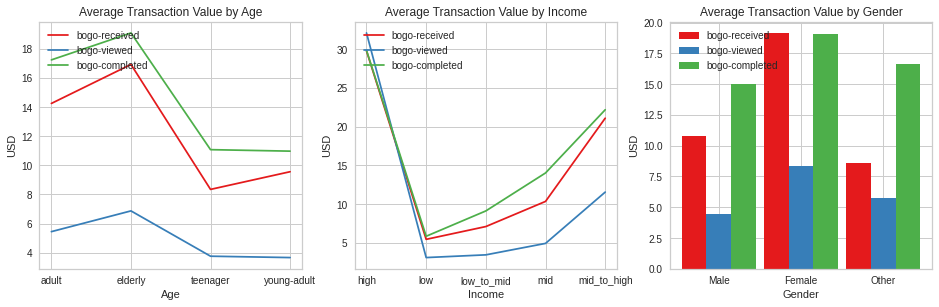

In [102]:
offer_earnings_plot(merged_cust, 'bogo')

The pattern in terms of offers, received, viewed and completed is the same accross age, income and gender demographics.

 * The elderly have the highest average transaction for BOGO offers. In general, as age increases, customers spend more on BOGO.

 * High income earners spend the highest on BOGO followed by mid-to-high earners. In general we observe an increase in spending with an increase in income.

* Females spend the most on BOGO but in terms of view rate, those that did not specfy gender spent more on BOGO if we compare how many received vs how many completed BOGO.

**Plot discount offer earnings**

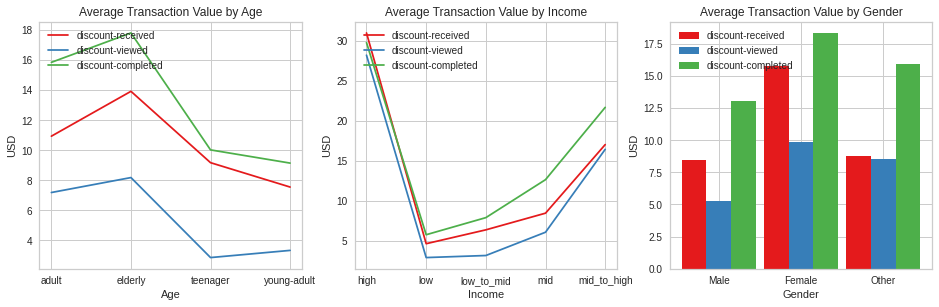

In [103]:
offer_earnings_plot(merged_cust, 'discount')

The same trends we observed for BOGO seem to apply here as well.

Transactions increase with an increase in age with those above 60 spending the most on discounts.

High income earners will spend an average of 30USD on discount offers. Mid to high earners will also spent a lot on discount

Females are also the highest spenders on discount earners and again we see those with unspecified gender have a higher conversion rate of all demographics

**Plot informational offer earnings**

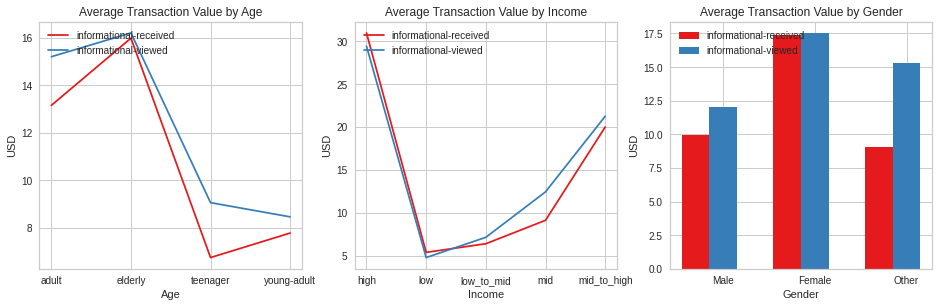

In [104]:
offer_earnings_plot(merged_cust, 'informational')

Informational offers follow the same pattern seen on all offers.

#### Get the money gained by customers for completed offers

In [105]:
def net_earnings(merged_cust, offer, q=0.5):  
    '''Get the net_earnings for customers that viewed and completed offers 
    INPUT:
    offer - offer of interest
    q - quantile to be used
    
    RETURNS:
    net_earnings - median of total transaction value
    '''
    # Flag customers that viewed offers
    flag = (merged_cust['{}_viewed'.format(offer)] > 0)
    # Sort through positive net earnings
    flag = flag & (merged_cust.net_expense > 0)
    # Aggregate those with at least 5 transactions
    flag = flag & (merged_cust.total_transactions >= 5)
    # Aggregate viewed and completed offers
    if offer not in ['info_1', 'info_2']:
        flag = flag & (merged_cust['{}_completed'.format(offer)] > 0)
    return merged_cust[flag].net_expense.quantile(q)

In [106]:
net_earnings(merged_cust,'bogo')

129.85999999999999

In [107]:
# Define loop that sorts by highest earnings
def greatest_earnings(merged_cust, n_top=2, q=0.5, offers=None):
    '''Sort offers based on the ones that result in the highest net_expense
    INPUT:
    customers - dataframe with aggregated data of the offers
    n_top - number of offers to be returned (default: 2)
    q - quantile used for sorting
    offers - list of offers to be sorted
    
    RETURNS:
    sorted list of offers, in descending order according to the median net_expense
    '''
    # Sort for offers earnings in second quantile
    if not offers:
        offers = ['bogo_1','bogo_2','bogo_3','bogo_4',
               'discount_1','discount_2','discount_3','discount_4',
               'info_1','info_2']
    offers.sort(key=lambda x: net_earnings(merged_cust, x, q), reverse=True)
    offers_dict = {o: net_earnings(merged_cust, o, q) for o in offers}
    return offers[:n_top], offers_dict

In [108]:
# Print 5 offers by most to least popular, highest to least highest earnings
offers = greatest_earnings(merged_cust, n_top=5)

In [109]:
offers

(['discount_1', 'bogo_1', 'bogo_4', 'bogo_3', 'bogo_2'],
 {'discount_1': 145.425,
  'bogo_1': 145.325,
  'bogo_4': 145.23000000000002,
  'bogo_3': 131.14,
  'bogo_2': 131.03,
  'discount_2': 124.99000000000001,
  'discount_3': nan,
  'discount_4': 138.07999999999998,
  'info_1': 124.17000000000002,
  'info_2': 102.96000000000001})

### Create another  merge for more analysis

Create a new dataframe that will combine transaction data with offer type such that the data about offers received, viewed and completed for each offer type are in one row.

In [110]:
updated_cleaned_transcript=pd.read_csv('./updated_clean_transcript.csv')

In [111]:
portfolio_clean

,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,3,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,2,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,2,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,1,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,2,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [112]:
profile[:5]

,gender,customer_id,year,quarter,age_group,income_range,member_type
1,F,0610b486422d4921ae7d2bf64640c50b,2017,3,3,5,1.0
3,F,78afa995795e4d85b5d9ceeca43f5fef,2017,2,4,5,1.0
5,M,e2127556f4f64592b11af22de27a7932,2018,2,4,3,1.0
8,M,389bc3fa690240e798340f5a15918d5c,2018,1,4,3,1.0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,2017,4,3,3,1.0


In [113]:
profile_transcript_df=profile.merge(updated_cleaned_transcript, on='customer_id', how='right')

In [114]:
len(profile_transcript_df) == len(updated_cleaned_transcript)

True

In [115]:
complete_df = portfolio_clean.merge(profile_transcript_df, on='offer_id', how='right')

Create a copy of the merged dataframe for EDA

In [116]:
master_df=complete_df.copy()

Create another copy that we will use for customer segmentation

In [117]:
clustering_df=master_df.copy()

In [118]:
# reconverting the values of the following features from numerical values to its original categorical values.
master_df['offer_type'] = master_df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})
master_df['income_range'] = master_df['income_range'].map({1: 'low', 2: 'low_to_mid', 3:'mid',4:'mid_to_high',5:'high'})
master_df['age_group'] = master_df['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})
master_df['member_type'] = master_df['member_type'].map({1: 'new', 2: 'regular', 3:'loyal'})

In [119]:
master_df['offer_type'].value_counts()

BOGO             50077
Discount         47491
Informational    22660
Name: offer_type, dtype: int64

#### Connect "transaction" with "informational" offer

We want to connect informational offer with transaction done. Such that all the offer completed rows can show the offer type that was completed. Then all the remaining transactions will be for uncompleted offers. To find such transactions, we need to make sure that:

1. Offer type is "informational"
1. Customer saw the offer - "offer_viewed" is true
2. The same customer made a purchase within **offer validity period**

In [120]:
%time
##added offer received to see what it does
print("Total rows: {}".format(len(master_df)))
print('Total "transaction" rows: {}'.format(len(master_df[master_df.event == "transaction"])))

rows_to_drop = [] 

# Check all informational offers that were viewed:
informational_df = master_df.loc[(master_df.offer_type == "Informational")  & (master_df.event == "offer viewed")]
for index, row in informational_df.iterrows():
    
    customer = master_df.at[index, 'customer_id'] # get customer id
    duration_hrs = master_df.at[index, 'offer_duration_days'] # get offer duration
    viewed_time = master_df.at[index, 'time'] # get the time when offer was viewed
    
    # Check all transactions of this particular customer:
    transaction_df = master_df.loc[(master_df.event == "transaction") & (master_df.customer_id == customer)]
    for transaction_index, transaction_row in transaction_df.iterrows():
                
        if master_df.at[transaction_index, 'time'] >= viewed_time: # transaction was AFTER offer was viewed
            if (master_df.at[transaction_index, 'time'] - viewed_time) >= duration_hrs: # offer was still VALID
                
                print("Updating row nr. " + str(index)
                      + " "*100, end="\r") # erase output and print on the same line
               
                # Update the event (offer viewed) row:
                master_df.at[index, 'money_spent'] = master_df.at[transaction_index, 'money_spent']
                master_df.at[index, 'event'] = "offer completed"
                master_df.at[index, 'offer_completed'] = 1
                master_df.at[index, 'transaction'] = 1
                master_df.at[index, 'time'] = master_df.at[transaction_index, 'time']
                
                # Drop the transaction row later:
                rows_to_drop.append(transaction_index)  
                
                break # to skip any later transactions and just use the first one that matches our search
        

master_df = master_df[~master_df.index.isin(rows_to_drop)] # faster alternative to dropping rows one by one

print("Rows after job is finished: {}".format(len(master_df)))
print("Transaction rows after job is finished: {}".format(len(master_df[master_df.event == "transaction"])))

master_df[(master_df.offer_type == "Informational") & (master_df.event == "offer completed")].head(3)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs
Total rows: 214604
Total "transaction" rows: 94376
Rows after job is finished: 208256                                                                                         
Transaction rows after job is finished: 88028


,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,gender,...,Unnamed: 0,event,time,money_spent,money_gained,offer_completed,offer_received,offer_viewed,transaction,auto_completed
105909,0.0,0.0,3.0,Informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0,F,...,85291,offer completed,15.75,23.93,0.0,1,0,1,1,0
105911,0.0,0.0,3.0,Informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0,F,...,123541,offer completed,19.00,23.30,0.0,1,0,1,1,0
105913,0.0,0.0,3.0,Informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0,F,...,77214,offer completed,15.00,22.99,0.0,1,0,1,1,0


In [121]:
print("Number of informational offers that were viewed but not completed:")
len(master_df[(master_df.offer_type == "Informational") & (master_df.event == "offer viewed")])

Number of informational offers that were viewed but not completed:


2778

#### Connect "transaction" with "bogo" offer

We want to connect bogo offer with transaction done. Such that all the offer completed rows can show the offer type that was completed. Then all the remaining transactions will be for uncompleted offers. To find such transactions, we need to make sure that:

1. Offer type is "informational"
1. Customer received saw the offer - "offer_viewed" is true
2. The same customer made a purchase within **offer validity period**

In [122]:
%time
##added offer received to see what it does
print("Total rows: {}".format(len(master_df)))
print('Total "transaction" rows: {}'.format(len(master_df[master_df.event == "transaction"])))

rows_to_drop = [] 

# Check all informational offers that were viewed:
informational_df = master_df.loc[(master_df.offer_type == "BOGO")  & (master_df.event == "offer viewed")]
for index, row in informational_df.iterrows():
    
    customer = master_df.at[index, 'customer_id'] # get customer id
    duration_hrs = master_df.at[index, 'offer_duration_days'] # get offer duration
    viewed_time = master_df.at[index, 'time'] # get the time when offer was viewed
    
    # Check all transactions of this particular customer:
    transaction_df = master_df.loc[(master_df.event == "transaction") & (master_df.customer_id == customer)]
    for transaction_index, transaction_row in transaction_df.iterrows():
                
        if master_df.at[transaction_index, 'time'] >= viewed_time: # transaction was AFTER offer was viewed
            if (master_df.at[transaction_index, 'time'] - viewed_time) >= duration_hrs: # offer was still VALID
                
                print("Updating row nr. " + str(index)
                      + " "*100, end="\r") # erase output and print on the same line
               
                # Update the event (offer viewed) row:
                master_df.at[index, 'money_spent'] = master_df.at[transaction_index, 'money_spent']
                master_df.at[index, 'event'] = "offer completed"
                master_df.at[index, 'offer_completed'] = 1
                master_df.at[index, 'transaction'] = 1
                master_df.at[index, 'time'] = master_df.at[transaction_index, 'time']
                
                # Drop the transaction row later:
                rows_to_drop.append(transaction_index)  
                
                break # to skip any later transactions and just use the first one that matches our search
        

master_df = master_df[~master_df.index.isin(rows_to_drop)] # faster alternative to dropping rows one by one

print("Rows after job is finished: {}".format(len(master_df)))
print("Transaction rows after job is finished: {}".format(len(master_df[master_df.event == "transaction"])))

master_df[(master_df.offer_type == "BOGO") & (master_df.event == "offer completed")].head(3)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.7 µs
Total rows: 208256
Total "transaction" rows: 88028
Rows after job is finished: 203163                                                                                         
Transaction rows after job is finished: 82935


,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,gender,...,Unnamed: 0,event,time,money_spent,money_gained,offer_completed,offer_received,offer_viewed,transaction,auto_completed
1,5.0,5.0,7.0,BOGO,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,F,...,47583,offer completed,5.50,19.89,5.0,1,0,1,1,0
6,5.0,5.0,7.0,BOGO,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,200086,offer completed,20.75,15.63,5.0,1,0,1,1,0
18,5.0,5.0,7.0,BOGO,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,29498,offer completed,16.25,1.54,0.0,1,0,1,1,0


In [123]:
print("Number of BOGO offers that were viewed but not completed:")
len(master_df[(master_df.offer_type == "BOGO") & (master_df.event == "offer viewed")])

Number of BOGO offers that were viewed but not completed:


3958

#### Connect "transaction" with "discount" offer

We want to connect bogo offer with transaction done. Such that all the offer completed rows can show the offer type that was completed. Then all the remaining transactions will be for uncompleted offers. To find such transactions, we need to make sure that:

1. Offer type is "discount"
1. Customer received and saw the offer - "offer_viewed" is true
2. The same customer made a purchase within **offer validity period**

In [124]:
%time
##added offer received to see what it does
print("Total rows: {}".format(len(master_df)))
print('Total "transaction" rows: {}'.format(len(master_df[master_df.event == "transaction"])))

rows_to_drop = [] 

# Check all informational offers that were viewed:
informational_df = master_df.loc[(master_df.offer_type == "Discount") & (master_df.event == "offer received")
                                 & (master_df.event == "offer viewed")]
for index, row in informational_df.iterrows():
    
    customer = master_df.at[index, 'customer_id'] # get customer id
    duration_hrs = master_df.at[index, 'offer_duration_days'] # get offer duration
    viewed_time = master_df.at[index, 'time'] # get the time when offer was viewed
    
    # Check all transactions of this particular customer:
    transaction_df = master_df.loc[(master_df.event == "transaction") & (master_df.customer_id == customer)]
    for transaction_index, transaction_row in transaction_df.iterrows():
                
        if master_df.at[transaction_index, 'time'] >= viewed_time: # transaction was AFTER offer was viewed
            if (master_df.at[transaction_index, 'time'] - viewed_time) >= duration_hrs: # offer was still VALID
                
                print("Updating row nr. " + str(index)
                      + " "*100, end="\r") # erase output and print on the same line
               
                # Update the event (offer viewed) row:
                master_df.at[index, 'money_spent'] = master_df.at[transaction_index, 'money_spent']
                master_df.at[index, 'event'] = "offer completed"
                master_df.at[index, 'offer_completed'] = 1
                master_df.at[index, 'transaction'] = 1
                master_df.at[index, 'time'] = master_df.at[transaction_index, 'time']
                
                # Drop the transaction row later:
                rows_to_drop.append(transaction_index)  
                
                break # to skip any later transactions and just use the first one that matches our search
        

master_df = master_df[~master_df.index.isin(rows_to_drop)] # faster alternative to dropping rows one by one

print("Rows after job is finished: {}".format(len(master_df)))
print("Transaction rows after job is finished: {}".format(len(master_df[master_df.event == "transaction"])))

master_df[(master_df.offer_type == "Discount") & (master_df.event == "offer completed")].head(3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Total rows: 203163
Total "transaction" rows: 82935
Rows after job is finished: 203163
Transaction rows after job is finished: 82935


,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,gender,...,Unnamed: 0,event,time,money_spent,money_gained,offer_completed,offer_received,offer_viewed,transaction,auto_completed
144112,2.0,10.0,7.0,Discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,F,...,77217,offer completed,8.0,27.23,2.0,1,0,1,1,0
144114,2.0,10.0,7.0,Discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,M,...,177270,offer completed,18.0,11.50,2.0,1,0,1,1,0
144118,2.0,10.0,7.0,Discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,M,...,106954,offer completed,13.0,115.00,2.0,1,0,1,1,0


In [125]:
print("Number of Discount offers that were viewed but not completed:")
len(master_df[(master_df.offer_type == "Discount") & (master_df.event == "offer viewed")])

Number of Discount offers that were viewed but not completed:


5460

### Distribution of Age Groups among customers

<AxesSubplot:xlabel='age_group', ylabel='count'>

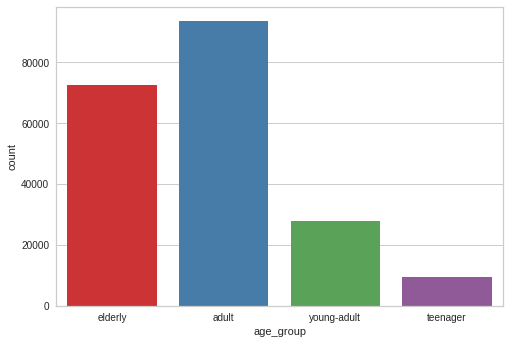

In [126]:
sns.countplot(master_df['age_group'])

In [127]:
master_df['age_group'].value_counts()

adult          93596
elderly        72478
young-adult    27734
teenager        9355
Name: age_group, dtype: int64

The distribution of ages among starbucks customers is skewed towards the older group. The elderly are the largest population followed by the adults. Teenagers are the smallest group

### Distribution of Gender among customers

<AxesSubplot:xlabel='gender', ylabel='count'>

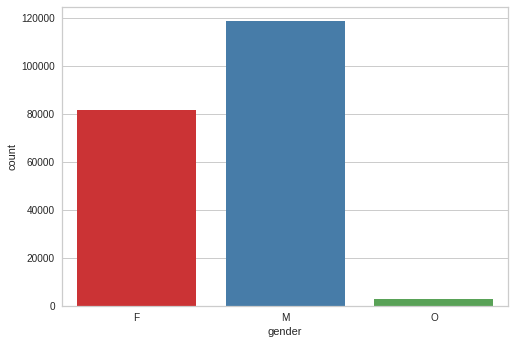

In [128]:
sns.countplot(master_df['gender'])

In [129]:
master_df['gender'].value_counts()

M    118718
F     81552
O      2893
Name: gender, dtype: int64

58.6 % of customers are male, 39.8% are female and 1.4% prefer not to specify gender

### Distribution of income among customers

<AxesSubplot:xlabel='income_range', ylabel='count'>

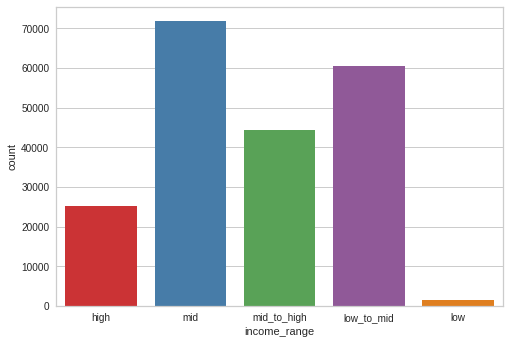

In [130]:
sns.countplot(master_df['income_range'])

Middle income and low_to_mid income earners  are occupy a huge proportion of the population, with mid income earners being the dorminant. Low earners are fewer, they are the least

#### Distribution of income by gender among customers

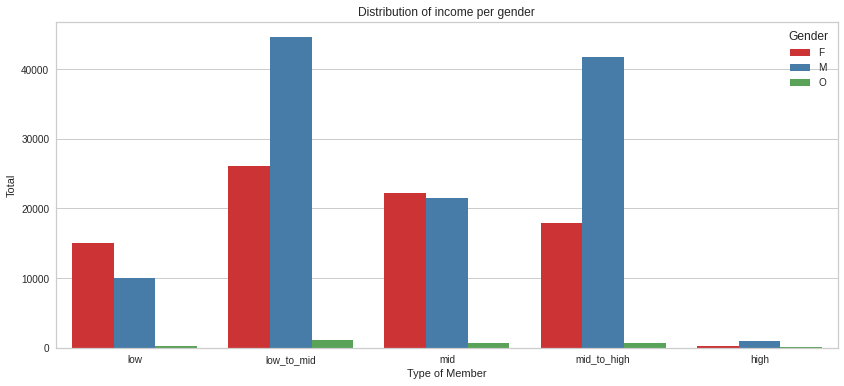

In [131]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="income_range", hue="gender", data=master_df)
plt.title('Distribution of income per gender')
plt.ylabel('Total')
plt.xlabel('Type of Member')
xlabels = ['low','low_to_mid','mid','mid_to_high','high']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Gender')
plt.show();

In [132]:
master_df.groupby(['income_range','gender']).customer_id.count()

income_range  gender
high          F         14980
              M          9945
              O           230
low           F           327
              M           953
              O            62
low_to_mid    F         17953
              M         41775
              O           726
mid           F         26124
              M         44576
              O          1170
mid_to_high   F         22168
              M         21469
              O           705
Name: customer_id, dtype: int64

Females are the highest earners. Most men are low to mid and mid earners. There's an almost equal distribution of male and females among the mid to high bracket

### Distribution of Offer Type and Offer ID during experiment

<AxesSubplot:xlabel='offer_type', ylabel='count'>

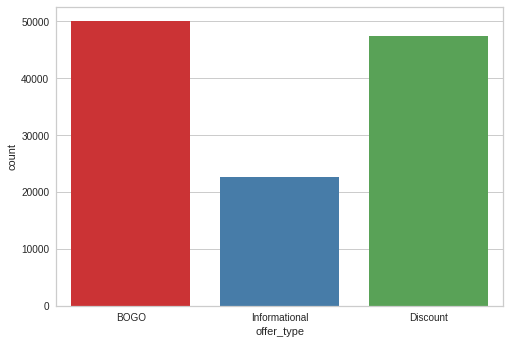

In [133]:
sns.countplot(master_df['offer_type'])


In [134]:
master_df['offer_type'].value_counts()

BOGO             50077
Discount         47491
Informational    22660
Name: offer_type, dtype: int64

There are 3 types of offers presented to customers, BOGO, discount and informational. BOGO and discount were sent out more.BOGO was the most distributed offer, 25% of distributed offers were BOGO, 23% were Discount and 11.2% were Informational offers. There were 10 different offers from the 3 different offer types, there were 4 types of BOGO offers, 4 types of discount offers and 2 types of informational offers.

### Distribution of offer received viewed and completed

Text(0.5, 1.0, 'Offer viewed Distribution')

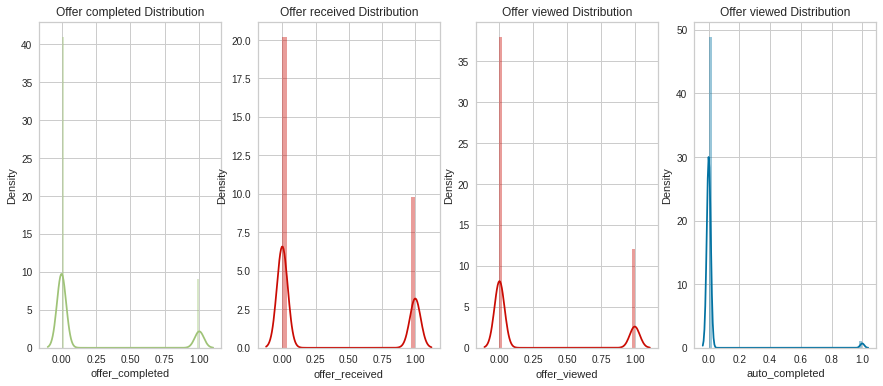

In [135]:
f, axes = plt.subplots(ncols=4, figsize=(15, 6))
sns.distplot(master_df.offer_completed, kde=True, color="g", ax=axes[0]).set_title('Offer completed Distribution')

sns.distplot(master_df.offer_received, kde=True, color="r", ax=axes[1]).set_title('Offer received Distribution')

sns.distplot(master_df.offer_viewed, kde=True, color="r", ax=axes[2]).set_title('Offer viewed Distribution')

sns.distplot(master_df.auto_completed, kde=True, color="b", ax=axes[3]).set_title('Offer viewed Distribution')

The distribution of offer data follows the same pattern. There were a lot of offers not completed vs those that were completed. The same with offers received, viewed and auto completed

### Distribution of Transactions for the offers

Text(0.5, 1.0, 'Offer type distribution - Transaction V.S. No Transaction')

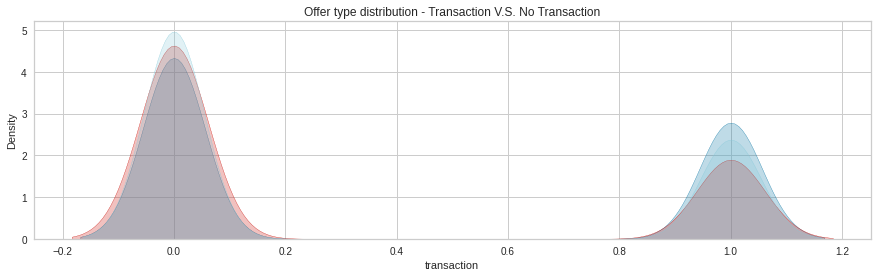

In [136]:
#KDEPlot: Kernel Density Estimate Plot

fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(master_df.loc[(master_df['offer_type'] == 'BOGO'),'transaction'] , color='b',shade=True)
ax=sns.kdeplot(master_df.loc[(master_df['offer_type'] == 'Informational'),'transaction'] , color='r',shade=True)
ax=sns.kdeplot(master_df.loc[(master_df['offer_type'] == 'Discount'),'transaction'] , color='c',shade=True)
plt.title('Offer type distribution - Transaction V.S. No Transaction')


The distribution of transactions done vs transactions not done for BOGO,Discount and Informational offers follows the same pattern. There was more transactions not done as compared to transactions completed

### Transactions done to complete offers

[Text(0, 0.5, 'Percent')]

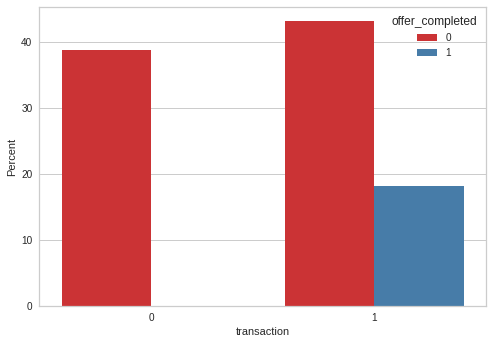

In [137]:
ax = sns.barplot(x="transaction", y="transaction", hue="offer_completed", data=master_df, estimator=lambda x: len(x) / len(master_df) * 100)
ax.set(ylabel="Percent")

### Auto completed transactions

[Text(0, 0.5, 'Percent')]

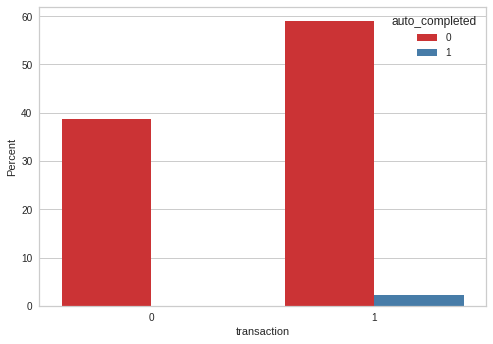

In [138]:
ax = sns.barplot(x="transaction", y="transaction", hue="auto_completed", data=master_df, estimator=lambda x: len(x) / len(master_df) * 100)
ax.set(ylabel="Percent")

#### Create a column for daily avg spending

Calculate how much a user spends or has spent on average since they became a member. Use the days of membership and became member on that we dropped before. We do this by creating a new df called data that groups how much money was spent by a customer by customer_id, gender, age group, income range and days of membership

First add that became member on column to the master_df

In [341]:
#create a dataframe just fr the became member on which we want to use for only a certain analysis on EDA
df1=pd.read_json('./profile.json', orient='records', lines=True)

In [342]:
df1.drop(columns=['gender','age','income'], inplace=True)

In [343]:
df1.rename(columns={'id': 'customer_id'}, inplace=True)

In [344]:
#change the became_member_on from int to datetime
df1['became_member_on'] = pd.to_datetime(df1['became_member_on'], format='%Y%m%d')

In [345]:
new_df=df1.merge(master_df, on='customer_id', how='right')

In [346]:
master_df=new_df

In [347]:
import datetime

data_collection_date = "2018-10-18"

master_df['days_of_membership'] = datetime.datetime.strptime(data_collection_date, '%Y-%m-%d') - master_df['became_member_on']
master_df['days_of_membership'] = master_df['days_of_membership'].dt.days.astype('int16')

In [348]:
# group data by person, calculate summary spend:
data = master_df.groupby(['customer_id', 'gender', 'age_group', 'income_range', 'days_of_membership','member_type'], as_index=False)['money_spent'].sum()

In [349]:
# Create new column "daily_spend_avg"
data['daily_spend_avg'] = data.money_spent / data.days_of_membership
data.sample(3)

,customer_id,gender,age_group,income_range,days_of_membership,member_type,money_spent,daily_spend_avg
11965,ce9ff37fcd4a4f6180ee3df63d6ce6c0,1,4,3,763,regular,106.77,0.139934
12349,d53ea893dd774977ad75280d4be4c621,1,3,2,445,new,10.04,0.022562
223,0409df7f3af74e8c813d975fbd4ceb02,1,4,4,1108,regular,64.20,0.057942


### Daily Average spend of customers by Gender

In [350]:
 #Custom colors that we will use in graphs:
custom_colors = ['#006241', '#84233C', '#1E3932', '#9D5116', '#E44C2C']

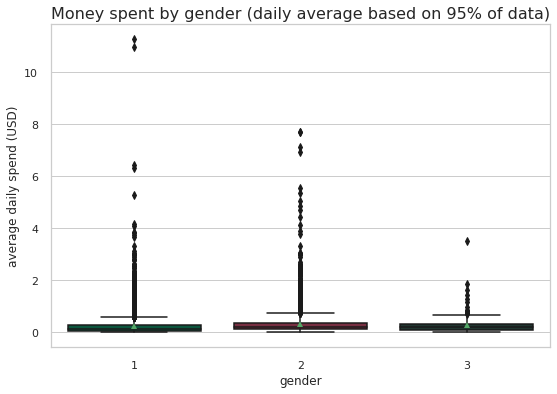

Mean values:
   gender  daily_spend_avg
0       1         0.218562
1       2         0.305103
2       3         0.276180


In [351]:
# create plot:
sns.boxplot(x="gender", y="daily_spend_avg", data=data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('average daily spend (USD)')
plt.xlabel('gender')
plt.title('Money spent by gender (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Mean values:")
print(data.groupby(['gender'], as_index=False)['daily_spend_avg'].mean())

plt.show()

By the shape of our plot there seem to be some outliers, customers who spend quite a substantial amount per day on average. Lets see these outliers and remove them

In [352]:
data.daily_spend_avg.describe()

count    14804.000000
mean         0.255175
std          0.377713
min          0.000000
25%          0.067523
50%          0.163119
75%          0.309466
max         11.286446
Name: daily_spend_avg, dtype: float64

As expected, the average daily spend for most customers is 0.25 US, but there are customers who max an average of 11.2US a day. We also see that the lower 75% percentile are 0.30US. We will remove anyone above this

In [353]:
data.daily_spend_avg.quantile(0.95)

0.7612370712384876

After a few iterations, we see that over 90% of customers spend 0.40US or less, only the 5% spend 0.70US and upwards, so we remove the 5%

In [354]:
# remove upper 5% outliers:
data = data[data.daily_spend_avg < data.daily_spend_avg.quantile(0.95)]

With the outliers removed, we check again the average money spent by gender

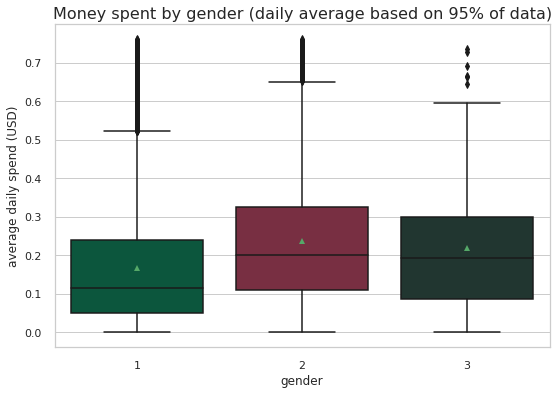

Mean values:
   gender  daily_spend_avg
0       1         0.167434
1       2         0.235465
2       3         0.219009


In [355]:
# create plot:
sns.boxplot(x="gender", y="daily_spend_avg", data=data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('average daily spend (USD)')
plt.xlabel('gender')
plt.title('Money spent by gender (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Mean values:")
print(data.groupby(['gender'], as_index=False)['daily_spend_avg'].mean())

plt.show()

Females are the highest spenders, they spend on average 0.23USD per day followed by gender O who spend 0.21USD per day and least spenders are males who spent on average 0.16USD. 

### Daily average spend of customers by Age Group

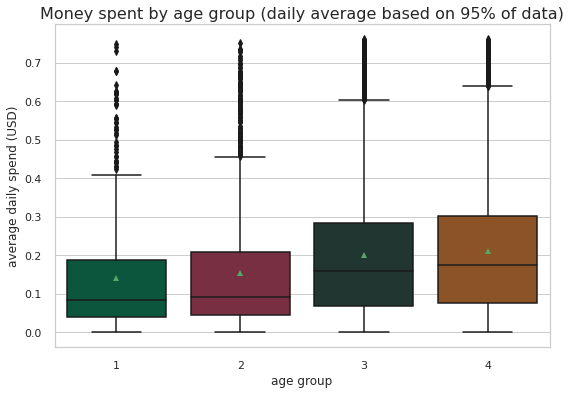

Mean values:
   age_group  daily_spend_avg
0          1         0.141821
1          2         0.153142
2          3         0.199117
3          4         0.211793


In [356]:
# create plot:
sns.boxplot(x="age_group", y="daily_spend_avg", data=data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('average daily spend (USD)')
plt.xlabel('age group')
plt.title('Money spent by age group (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Mean values:")
print(data.groupby(['age_group'], as_index=False)['daily_spend_avg'].mean())

plt.show()

The elderly, that is those above 60 are the highest age group spending an average of 0.21US per day. Adults, those aged 35-60 are the second highest spenders on average, spending 0.19US per day. Ages 17-34 are the least spenders, spending roughly 0.14US per day

### Daily average spend of customers by income range

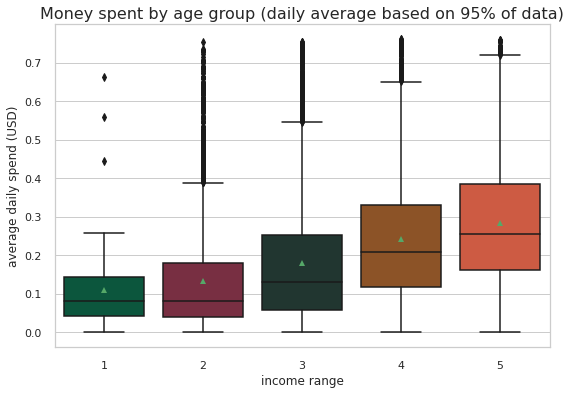

Mean values:
   income_range  daily_spend_avg
0             1         0.108308
1             2         0.133231
2             3         0.179468
3             4         0.240649
4             5         0.283618


In [357]:
# create plot:
sns.boxplot(x="income_range", y="daily_spend_avg", data=data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('average daily spend (USD)')
plt.xlabel('income range')
plt.title('Money spent by age group (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Mean values:")
print(data.groupby(['income_range'], as_index=False)['daily_spend_avg'].mean())

plt.show()

As expected, high income earners have the highest average spend. Spending on average, 0.28US per day, mid to high earners also spend highly with 0.23US per day. Low and low to mid income earners spend right around the same amount. They spend about 0.11US per day

### Daily Average spend by member type

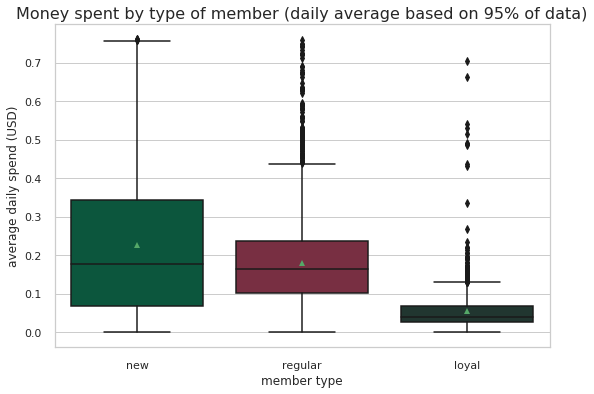

Mean values:
  member_type  daily_spend_avg
0       loyal         0.055500
1         new         0.225833
2     regular         0.178587


In [358]:
# create plot:
sns.boxplot(x="member_type", y="daily_spend_avg", data=data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('average daily spend (USD)')
plt.xlabel('member type')
plt.title('Money spent by type of member (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Mean values:")
print(data.groupby(['member_type'], as_index=False)['daily_spend_avg'].mean())

plt.show()

New members have the highest average dailly spend followed by regular members. Loyal members, those who have been members for over 3 years are no longer daily spenders

#### Money spent for duration of offer

In [369]:
new_data = master_df[master_df.money_spent < master_df.money_spent.quantile(0.95)]

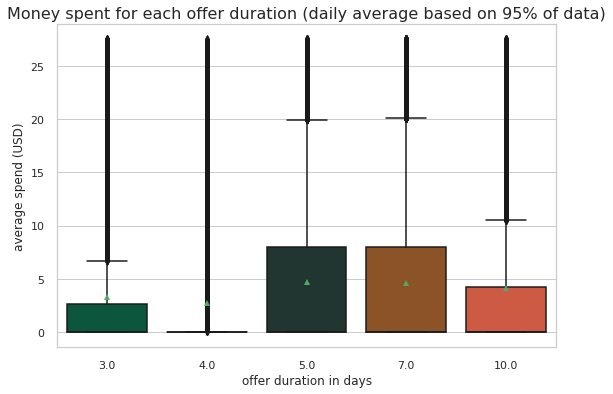

Mean values:
   offer_duration_days  money_spent
0                  3.0     4.402707
1                  4.0     4.005438
2                  5.0     6.907186
3                  7.0     6.593053
4                 10.0     6.539640


In [371]:
# create plot:
sns.boxplot(x="offer_duration_days", y="money_spent", data=new_data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('average spend (USD)')
plt.xlabel('offer duration in days')
plt.title('Money spent for each offer duration (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Mean values:")
print(master_df.groupby(['offer_duration_days'], as_index=False)['money_spent'].mean())

plt.show()

More money was spent for offers that lasted longer, on average 2USD more was spent on offers that lasted more than 5 days and more

Summary of average daily spending has revealed that:
* High earning elderly females who are new members have the highest daily average spend i.e Female members who are over 60 years earning over 90K and have been members for at least 1200 days


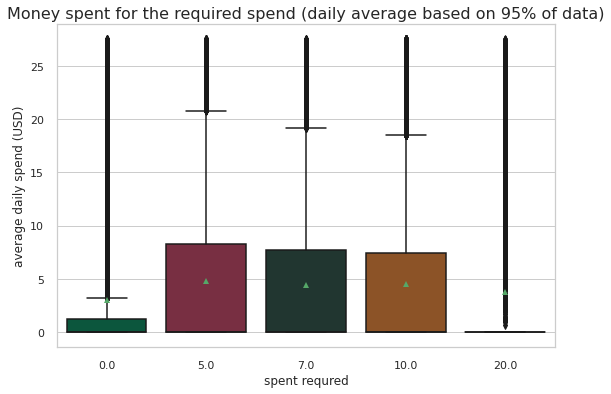

Mean values:
   spent_required  money_spent
0             0.0     4.224865
1             5.0     6.736110
2             7.0     6.279434
3            10.0     6.762536
4            20.0     6.492396


In [372]:
# create plot:
sns.boxplot(x="spent_required", y="money_spent", data=new_data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('average daily spend (USD)')
plt.xlabel('spent requred')
plt.title('Money spent for the required spend (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Mean values:")
print(master_df.groupby(['spent_required'], as_index=False)['money_spent'].mean())

plt.show()

The more spent required the more money was spent but it capped at 6.76USD

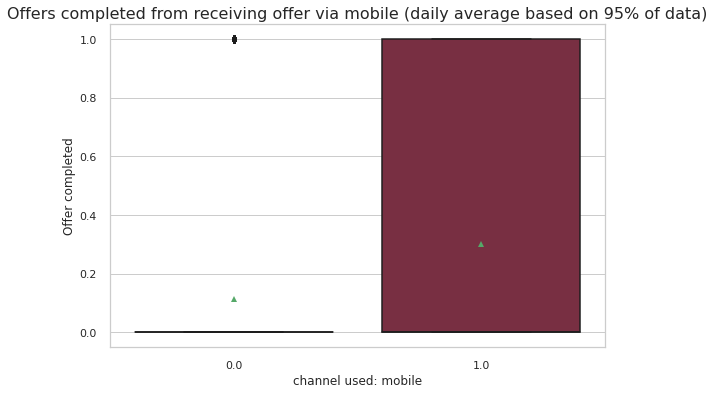

Sum of values:
   channel_mobile  offer_completed
0             0.0             1367
1             1.0            35532


In [376]:
# create plot:
sns.boxplot(x="channel_mobile", y="offer_completed", data=new_data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('Offer completed')
plt.xlabel('channel used: mobile')
plt.title('Offers completed from receiving offer via mobile (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Sum of values:")
print(master_df.groupby(['channel_mobile'], as_index=False)['offer_completed'].sum())

plt.show()

Most people who received offer via mobile completed it. It seems that mobile is the most important channel

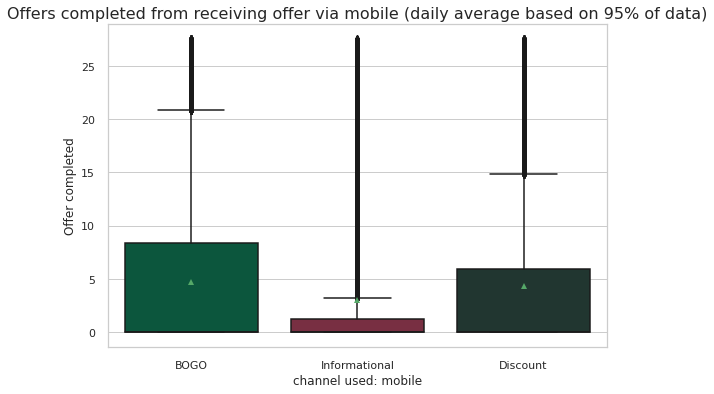

Sum of values:
      offer_type  money_spent
0           BOGO     6.851173
1       Discount     6.464640
2  Informational     4.224865


In [377]:
# create plot:
sns.boxplot(x="offer_type", y="money_spent", data=new_data, showmeans=True, palette=custom_colors)

plt.tight_layout(pad=1.4)
plt.ylabel('money spent per offer type')
plt.xlabel('offer type')
plt.title('Offers completed from receiving offer via mobile (daily average based on 95% of data)', fontsize=16)
plt.show()

print("Sum of values:")
print(master_df.groupby(['offer_type'], as_index=False)['money_spent'].mean())

plt.show()

### Distribution of offers among age groups

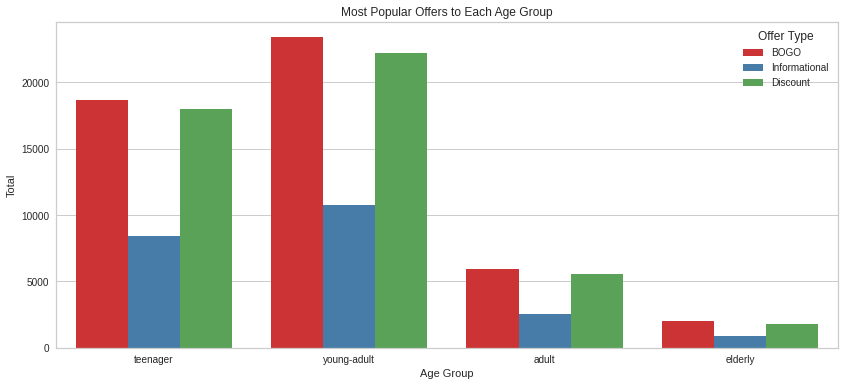

In [157]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();


In [158]:
master_df.groupby(['age_group','offer_type']).offer_id.count()

age_group    offer_type   
adult        BOGO             23393
             Discount         22207
             Informational    10774
elderly      BOGO             18690
             Discount         17956
             Informational     8426
teenager     BOGO              2023
             Discount          1800
             Informational      924
young-adult  BOGO              5971
             Discount          5528
             Informational     2536
Name: offer_id, dtype: int64

Overall across all age groups, BOGO is the most occuring type of offer. The distribution of offers follows the same pattern accross all age groups. BOGO being most popular closely followed by discount with the informational offers being the least by a margin. 

### Distribution of offers by Income Group

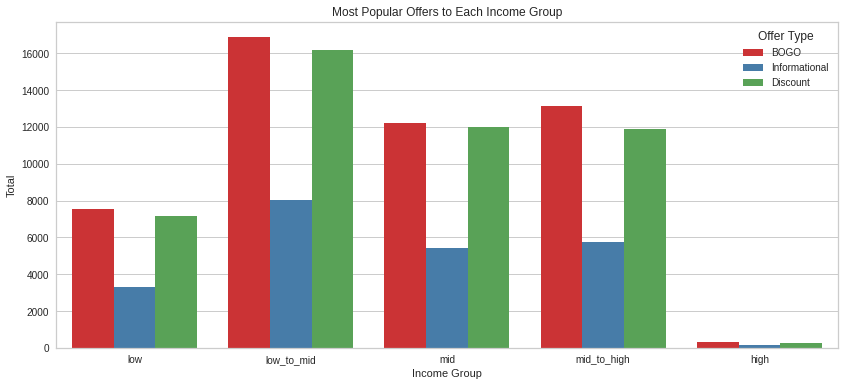

In [159]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="income_range", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Income Group')
plt.ylabel('Total')
plt.xlabel('Income Group')
xlabels = ['low','low_to_mid', 'mid','mid_to_high','high']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [160]:
master_df.groupby(['income_range','offer_type']).customer_id.count()

income_range  offer_type   
high          BOGO              7528
              Discount          7187
              Informational     3301
low           BOGO               302
              Discount           240
              Informational      128
low_to_mid    BOGO             13151
              Discount         11909
              Informational     5762
mid           BOGO             16877
              Discount         16173
              Informational     8027
mid_to_high   BOGO             12219
              Discount         11982
              Informational     5442
Name: customer_id, dtype: int64

Most offers are concentrated around low to mid income earners. The second highest number of offers were sent to mid and mid to high income earners. High earners received the least offers. In terms of pattern, the offers follow the same pattern accross all income groups


### Distribution of offers by Member Type

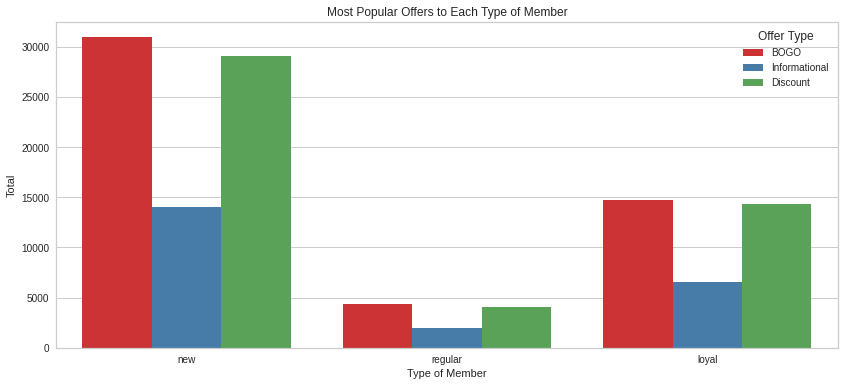

In [161]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="member_type", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Type of Member')
plt.ylabel('Total')
plt.xlabel('Type of Member')
xlabels = ['new','regular','loyal']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [162]:
master_df.groupby(['member_type','offer_type']).customer_id.count()

member_type  offer_type   
loyal        BOGO              4355
             Discount          4021
             Informational     1995
new          BOGO             30940
             Discount         29113
             Informational    14059
regular      BOGO             14697
             Discount         14302
             Informational     6571
Name: customer_id, dtype: int64

The highest number of offers were sent to new members followed by loyal members with regular members receiving the least amount of offers. In terms of popularity of offers, the same pattern consistently emerges of BOGO being highest with discount close by and low informational offers

### Distribution of Events per Type of Member

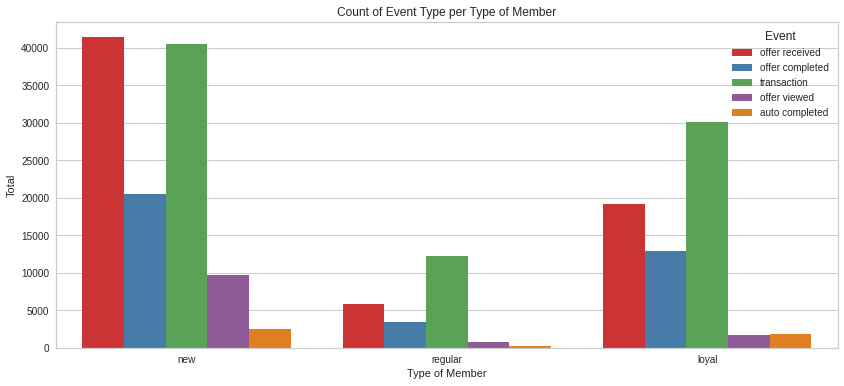

In [163]:
plt.figure(figsize=(14, 6))

g = sns.countplot(x="member_type", hue="event", data=master_df)
plt.title('Count of Event Type per Type of Member')
plt.ylabel('Total')
plt.xlabel('Type of Member')
xlabels = ['new','regular','loyal']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

In [164]:
master_df.groupby(['event','member_type']).customer_id.count()

event            member_type
auto completed   loyal            303
                 new             2497
                 regular         1829
offer completed  loyal           3485
                 new            20537
                 regular        12842
offer received   loyal           5785
                 new            41395
                 regular        19223
offer viewed     loyal            798
                 new             9683
                 regular         1676
transaction      loyal          12299
                 new            40539
                 regular        30036
Name: customer_id, dtype: int64

41 395 new customers received offers. Of those that received offers, only 41.5% viewed the offer and 37.5% completed the offer.

40 539 new customers made transactions on the app, new members made the highest number of transactions of all the members. Regular members also made a sizeable amount of transactions on the app, they made 30 036 transactions. Loyal members had the least number of transactions, making 12 299 transactions

Regular members were the second highest to receive offers, receiving 19 223 offers but only 24% viewing the offers and 60% completing the offers. Most regular members completed the offers without viewing them.

5785 loyal customers received offers, of this number, 38.2% viewed the offers and 41% completed the offers.


In [165]:
master_df.groupby(['event','member_type','offer_type']).offer_id.count()

event            member_type  offer_type   
auto completed   loyal        BOGO               127
                              Discount           176
                 new          BOGO              1099
                              Discount          1398
                 regular      BOGO               751
                              Discount          1078
offer completed  loyal        BOGO              1593
                              Discount          1251
                              Informational      641
                 new          BOGO             10156
                              Discount          6549
                              Informational     3832
                 regular      BOGO              5835
                              Discount          4904
                              Informational     2103
offer received   loyal        BOGO              2334
                              Discount          2291
                              Informational     1160
  

An indepth analysis of the types of offers given to customers shows interesting observations.

**On new customers:**

39.88% of new customers received BOGO offer, 41.4% of those that received the BOGO viewed it, which constituted 39.8% of all offer views by new customers. 45% of those new customers that received the BOGO completed it, accounting for 48.8% of all new customers that completed offers.

40% of new customers received the discount offer, 27.5% of those that received this offer viewed the offer, accounting for 26.6% of all offer views by new customers. 47.8% of new customers who received the discount offer completed it, which accounts for 51.1% of all offers completed by new customers.

20% of new customers received informational offers, 69.5% of them viewed it, which accounts for 33.5% of views by new customers.

None of the new customers completed informational offers.

**On regular customers:**

39.77% of regular customers received the BOGO offer, of these only 18% viewed it. This means that 29.4% of all views of BOGO offer were done by regular customers. 74% of regular customers who received the BOGO offer completed it. This accounts for 48.6% of all offers completed by regular customers

40.3% of regular customers received the discount offer, of these only 7% of them viewed it. This means that 12.1% of offer views by regular customers were viewing discount offer. 77.1% of regular customers who received discount offer completed it. This means 51.4% of all offers completed by regular customers was on discount offers.

19.91% of regular customers received the informational offer, of these 71.6% of them viewed it. 23.5% of all views made by regular customers were on informational offers.

None of the informational offers were completed.

**On loyal customers:**

40.3% of loyal customers received the BOGO offer, of these 46% of them viewed it. This means that, 48.85% of all loyal customer views were on BOGO. 40.5% of loyal customers who received BOGO completed it. This accounts for 39.86% of all offers completed by loyal customers.

39.6% of loyal customers received discount offer, 13.2% viewed it. This means that 13.7% of all views by loyal customers was on discount offer.62.28% of loyal customers who received the discount offer completed it. This accounts for 60% of all offers completed by loyal customers.





In [166]:
def calculate_percentage_success():
    '''Calculate percent success by offer
    INPUT:
    cleaned_df - dataframe with merged transaction, offer, and demographic data
    
    RETURNS:
    percent success by offer
    '''
    # Define variables, calculate percent success
    successful_count = cleaned_df[['offer_id', 'offer_completed']].groupby(
        'offer_id').sum().reset_index()
    offer_count = cleaned_df['offer_id'].value_counts()
    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])
    successful_count = successful_count.sort_values('offer_id')
    offer_count = offer_count.sort_values('offer_id')
    percent_success = pd.merge(offer_count, successful_count, on="offer_id")
    percent_success['percent_success'] = (100 * percent_success['offer_completed'] / percent_success['count'])
    percent_success = percent_success.drop(columns=['offer_completed'])
    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [167]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success
0,bogo_3,14372,29.139994
1,discount_4,14002,27.931724
2,fafdcd668e3743c1bb461111dcafc2a4,18062,27.699037
3,discount_1,12327,27.468159
4,discount_2,17920,27.265625
5,bogo_2,16989,24.150921
6,bogo_1,16241,22.517086
7,bogo_4,16232,20.391819
8,info_1,10144,0.000000
9,info_2,12516,0.000000


In [168]:
percent_success = percent_success.drop(percent_success.index[[8,9]])

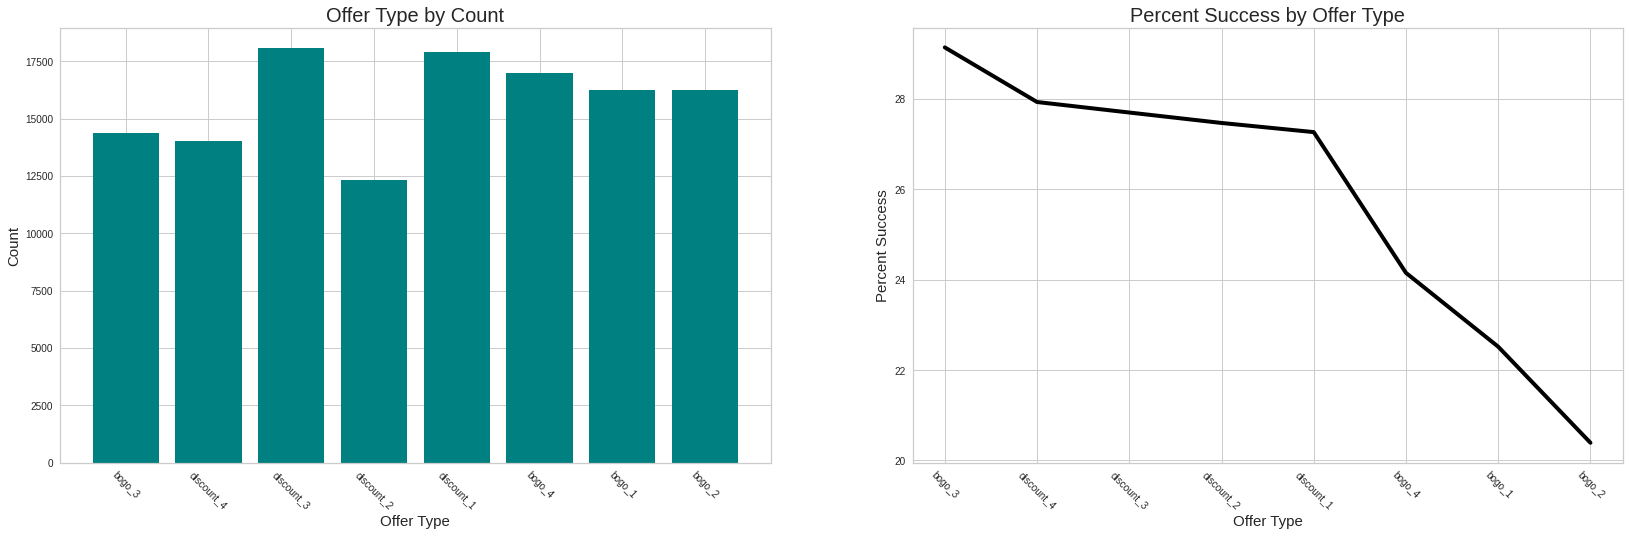

In [171]:
# Plot percent success by offer type
fig, ax = plt.subplots(figsize=(28, 8), nrows=1, ncols=2)

# Plot offer type by count
ax[0].bar(percent_success.index + 1, percent_success['count'], color='teal')
ax[0].set_xticks(np.arange(0,8) + 1)
ax[0].set_xlabel('Offer Type',size = 15)
ax[0].set_ylabel('Count',size = 15)
ax[0].set_title('Offer Type by Count', size = 20)
group_labels = ['bogo_3', 'discount_4', 'discount_3', 
                'discount_2', 'discount_1', 'bogo_4', 
                'bogo_1', 'bogo_2']
ax[0].set_xticklabels(group_labels, rotation=-45)


ax[1].plot(percent_success.index + 1, percent_success['percent_success'], linewidth=4.0, color='black')
ax[1].set_xticks(np.arange(0,8) + 1)
ax[1].set_xlabel('Offer Type',size = 15)
ax[1].set_ylabel('Percent Success',size = 15)
ax[1].set_title('Percent Success by Offer Type', size = 20)
ax[1].set_xticklabels(group_labels, rotation=-45)
group_labels = ['bogo_3', 'discount_4', 'discount_3', 
                'discount_2', 'discount_1', 'bogo_4', 
                'bogo_1', 'bogo_2']

The bogo_3 is the most succesful offer with 29% success. The discount offers perfomed pretty well averaging 27%.

### Distribution of Events per Gender

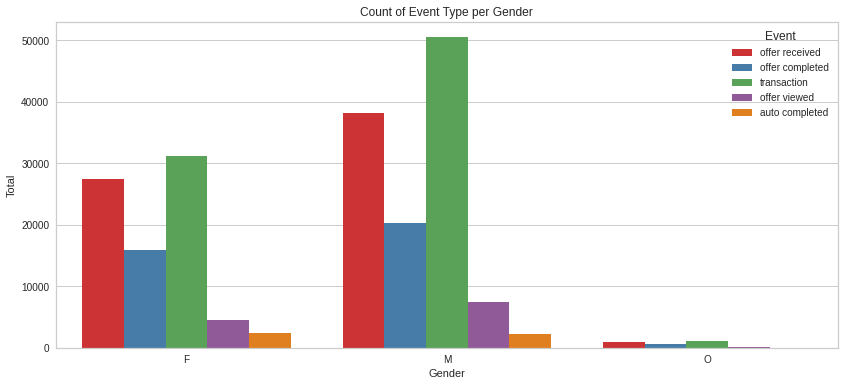

In [172]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="event", data=master_df)
plt.title('Count of Event Type per Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

In [173]:
master_df.groupby(['event','gender','offer_type']).customer_id.count()

event            gender  offer_type   
auto completed   F       BOGO               995
                         Discount          1360
                 M       BOGO               963
                         Discount          1271
                 O       BOGO                20
                         Discount            23
offer completed  F       BOGO              7566
                         Discount          5742
                         Informational     2668
                 M       BOGO              9785
                         Discount          6762
                         Informational     3809
                 O       BOGO               253
                         Discount           209
                         Informational      105
offer received   F       BOGO             10975
                         Discount         10943
                         Informational     5538
                 M       BOGO             15208
                         Discount         15354
 

In [174]:
print("Number of BOGO offers that were received by females but not completed:")
len(master_df[(master_df.offer_type == "BOGO") & (master_df.gender == "F") & (master_df.event == "offer received")])

Number of BOGO offers that were received by females but not completed:


10975

> **Female BOGO offer**:
* 10 975 females received the BOGO offers, 1368 viewed it but did not complete it. 7566 received and completed it. Only 995 of them auto completed it.
> **Female Discount offer**:
* 10 943 females received the Discount offers, 1267 viewed but did not complete. 6369 received and completed it.1360 of them auto completed it.
> **Female Informational offer**:
* 5538 females received the informational offer, 1242 viewed but did not complete the offer. 2668 received and completed the offer. 

> **Male BOGO offer**:
* 15 208 males received the BOGO offer. Of these 2534 viewed the offer but did not complete it. 9785 received and completed the offer. 963 completed the offer automatically.
> **Male Discount offer**:
* 15 354 males received the discount offer. Of these 2201 males only viewed the offer. 8049 received and completed the offer. 1271 auto completed the offer
>**Male Informational offer**:
* 7567 males received the informational offer. 1480 males viewed the offer without completing it. 3809 received and completed it

>**Gender unspecified BOGO offer**:
* 354 of these customers received the offer. 56 only viewed the offer. 253 received and completed the offer while 20 auto completed it.



### Distribution of Events per Income range

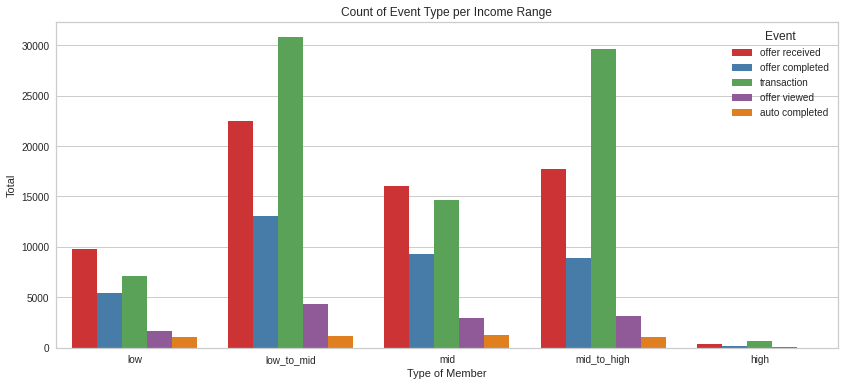

In [175]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="income_range", hue="event", data=master_df)
plt.title('Count of Event Type per Income Range')
plt.ylabel('Total')
plt.xlabel('Type of Member')
xlabels = ['low','low_to_mid','mid','mid_to_high','high']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

In [176]:
master_df.groupby(['event','income_range']).customer_id.count()

event            income_range
auto completed   high             1052
                 low                18
                 low_to_mid       1088
                 mid              1205
                 mid_to_high      1269
offer completed  high             5466
                 low               187
                 low_to_mid       8869
                 mid             13039
                 mid_to_high      9338
offer received   high             9814
                 low               396
                 low_to_mid      17715
                 mid             22495
                 mid_to_high     16081
offer viewed     high             1684
                 low                69
                 low_to_mid       3150
                 mid              4338
                 mid_to_high      2955
transaction      high             7139
                 low               672
                 low_to_mid      29632
                 mid             30793
                 mid_to_high     1

Mid income earners received and completed the most offers and made the most transactions.

Low to mid income earners were the second highest in terms of offers received and completed.

In [177]:
master_df.groupby(['event','offer_type','income_range']).customer_id.count()

event            offer_type     income_range
auto completed   BOGO           high             434
                                low                9
                                low_to_mid       473
                                mid              504
                                mid_to_high      558
                 Discount       high             618
                                low                9
                                low_to_mid       615
                                mid              701
                                mid_to_high      711
offer completed  BOGO           high            2621
                                low              100
                                low_to_mid      4420
                                mid             6095
                                mid_to_high     4368
                 Discount       high            2038
                                low               50
                                low_to_mid      2679
 

### Distribution of events by age group

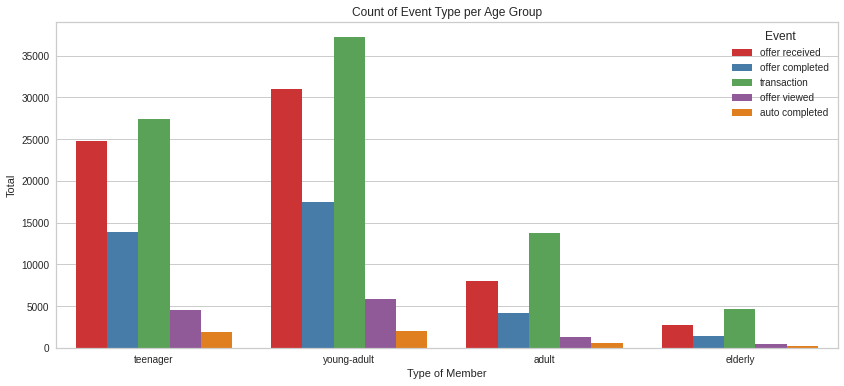

In [178]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="event", data=master_df)
plt.title('Count of Event Type per Age Group')
plt.ylabel('Total')
plt.xlabel('Type of Member')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Event')
plt.show();

In [179]:
master_df.groupby(['event','age_group']).customer_id.count()

event            age_group  
auto completed   adult           2054
                 elderly         1859
                 teenager         166
                 young-adult      553
offer completed  adult          17478
                 elderly        13889
                 teenager        1380
                 young-adult     4152
offer received   adult          30957
                 elderly        24808
                 teenager        2714
                 young-adult     8022
offer viewed     adult           5885
                 elderly         4516
                 teenager         487
                 young-adult     1308
transaction      adult          37222
                 elderly        27406
                 teenager        4608
                 young-adult    13699
Name: customer_id, dtype: int64

#### Analysis of those who completed the offer by age group

In [180]:
completed = master_df[master_df['offer_completed']==1]

completed = pd.DataFrame(completed.age_group.value_counts()).reset_index()
not_completed = pd.DataFrame(master_df.age_group.value_counts()).reset_index()

merge = pd.merge(completed, not_completed, how='inner', on='index')

merge = merge.rename(columns={"age_group_x":'completed', "age_group_y":'not_completed', "index":'age_group' })

merge


,age_group,completed,not_completed
0,adult,17478,93596
1,elderly,13889,72478
2,young-adult,4152,27734
3,teenager,1380,9355


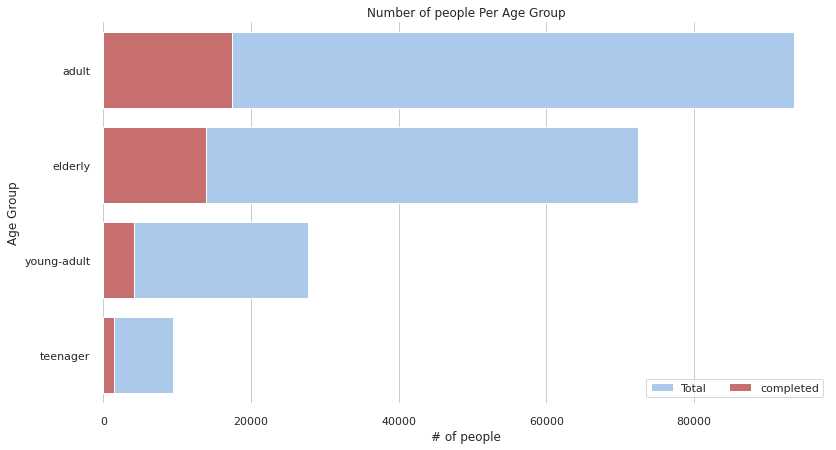

In [181]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total schools per city
sns.set_color_codes("pastel")
sns.barplot(x="not_completed", y='age_group', data=merge,
            label="Total", color="b")

# Plot the total community schools per city
sns.set_color_codes("muted")
sns.barplot(x="completed", y="age_group", data=merge,
            label="completed", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Age Group", title='Number of people Per Age Group',
       xlabel="# of people")
sns.despine(left=True, bottom=True)

In [182]:
master_df.groupby(['event','age_group']).customer_id.count()

event            age_group  
auto completed   adult           2054
                 elderly         1859
                 teenager         166
                 young-adult      553
offer completed  adult          17478
                 elderly        13889
                 teenager        1380
                 young-adult     4152
offer received   adult          30957
                 elderly        24808
                 teenager        2714
                 young-adult     8022
offer viewed     adult           5885
                 elderly         4516
                 teenager         487
                 young-adult     1308
transaction      adult          37222
                 elderly        27406
                 teenager        4608
                 young-adult    13699
Name: customer_id, dtype: int64

#### Clusters of those who completed the offer

In [183]:
## For the KDEs and Clustering, we need the cat variables numeric

master_df['income_range'] = master_df['income_range'].map({'low': 1, 'low_to_mid': 2, 'mid':3, 'mid_to_high':4, 'high':5})
master_df['age_group'] = master_df['age_group'].map({'teenager':1 , 'young-adult': 2, 'adult':3, 'elderly':4})
master_df['gender'] = master_df['gender'].map({'M':1 , 'F': 2, 'O':3})

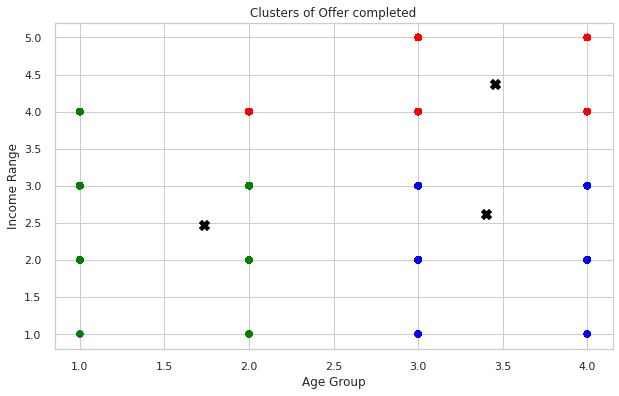

In [184]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of offer completed
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(new_df[new_df.offer_completed==1][["age_group","income_range"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x="age_group",y="income_range", data=new_df[new_df.offer_completed==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Age Group")
plt.ylabel("Income Range")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Offer completed")
plt.show()


There are 3 clusters of those that completed the offer those that were older and had high income. 
Those that were older and had mid income and those that were middle aged and middle income earners. We will do an advanced customer segmentation 

#### Age distribution of those who completed the offer

Text(0.5, 1.0, 'Age Distribution - Offer completed V.S. Offer not completed')

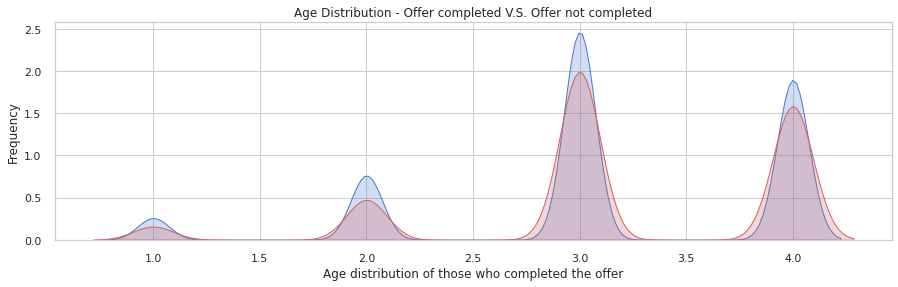

In [185]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(master_df.loc[(master_df['offer_completed'] == 0),'age_group'] ,label='offer not completed', color='b',shade=True )
ax=sns.kdeplot(master_df.loc[(master_df['offer_completed'] == 1),'age_group'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Age distribution of those who completed the offer', ylabel='Frequency')
plt.title('Age Distribution - Offer completed V.S. Offer not completed')


Most of the customers that completed offers were adults and the elderly. The least to complete offers were the teens and young adults

#### Income distribution of those who completed the offer

Text(0.5, 1.0, 'Income Distribution - Offer completed V.S. Offer not completed')

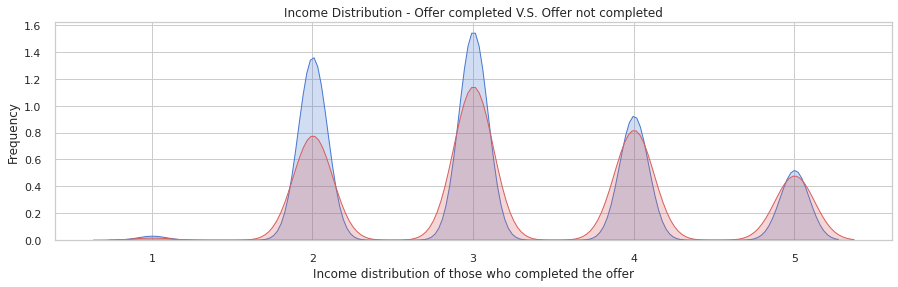

In [186]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(master_df.loc[(master_df['offer_completed'] == 0),'income_range'] ,label='offer not completed', color='b',shade=True )
ax=sns.kdeplot(master_df.loc[(master_df['offer_completed'] == 1),'income_range'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Income distribution of those who completed the offer', ylabel='Frequency')
plt.title('Income Distribution - Offer completed V.S. Offer not completed')


The bulk of those that completed offers were low to mid and mid income earners

<a id=segmentation><a/>
## Creating customer clusters using KNN

In [187]:
clustering_df

,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,gender,...,Unnamed: 0,event,time,money_spent,money_gained,offer_completed,offer_received,offer_viewed,transaction,auto_completed
0,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,F,...,0,offer received,0.0,0.00,0.0,0,1,0,0,0
1,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,F,...,47583,offer completed,5.5,19.89,5.0,1,0,1,1,0
2,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,150600,offer received,17.0,0.00,0.0,0,1,0,0,0
3,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,171209,offer viewed,17.5,0.00,0.0,0,0,1,0,0
4,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,53179,offer received,7.0,0.00,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,M,...,217850,offer viewed,21.0,0.00,0.0,0,0,1,0,0
214600,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,M,...,257182,offer received,24.0,0.00,0.0,0,1,0,0,0
214601,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,M,...,261927,offer viewed,24.0,0.00,0.0,0,0,1,0,0
214602,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,F,...,253904,offer received,24.0,0.00,0.0,0,1,0,0,0


In [188]:
cust_df=clustering_df

In [189]:
cust_df

,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,gender,...,Unnamed: 0,event,time,money_spent,money_gained,offer_completed,offer_received,offer_viewed,transaction,auto_completed
0,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,F,...,0,offer received,0.0,0.00,0.0,0,1,0,0,0
1,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,F,...,47583,offer completed,5.5,19.89,5.0,1,0,1,1,0
2,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,150600,offer received,17.0,0.00,0.0,0,1,0,0,0
3,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,171209,offer viewed,17.5,0.00,0.0,0,0,1,0,0
4,5.0,5.0,7.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,M,...,53179,offer received,7.0,0.00,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,M,...,217850,offer viewed,21.0,0.00,0.0,0,0,1,0,0
214600,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,M,...,257182,offer received,24.0,0.00,0.0,0,1,0,0,0
214601,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,M,...,261927,offer viewed,24.0,0.00,0.0,0,0,1,0,0
214602,10.0,10.0,5.0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,F,...,253904,offer received,24.0,0.00,0.0,0,1,0,0,0


In [190]:
#map the values back to their categorical variables
cust_df['income_range'] = cust_df['income_range'].map({1: 'low', 2: 'low_to_mid', 3:'mid',4:'mid_to_high',5:'high'})
cust_df['age_group'] = cust_df['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})
cust_df['member_type'] = cust_df['member_type'].map({1: 'new', 2: 'regular', 3:'loyal'})
cust_df['offer_type'] = cust_df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})

In [191]:
columns_to_keep = ['gender',
 'age_group',
 'customer_id',
 'income_range',
 'member_type',
 'money_spent',
 'money_gained',
 'offer_type',                  
 'offer_completed',
 'offer_duration_days',
 'time',
 'offer_viewed',
 'transaction',
 'auto_completed']

In [192]:
cust_df = cust_df[columns_to_keep]

In [193]:
cust_df

,gender,age_group,customer_id,income_range,member_type,money_spent,money_gained,offer_type,offer_completed,offer_duration_days,time,offer_viewed,transaction,auto_completed
0,F,elderly,78afa995795e4d85b5d9ceeca43f5fef,high,new,0.00,0.0,BOGO,0,7.0,0.0,0,0,0
1,F,elderly,78afa995795e4d85b5d9ceeca43f5fef,high,new,19.89,5.0,BOGO,1,7.0,5.5,1,1,0
2,M,elderly,e2127556f4f64592b11af22de27a7932,mid,new,0.00,0.0,BOGO,0,7.0,17.0,0,0,0
3,M,elderly,e2127556f4f64592b11af22de27a7932,mid,new,0.00,0.0,BOGO,0,7.0,17.5,1,0,0
4,M,elderly,389bc3fa690240e798340f5a15918d5c,mid,new,0.00,0.0,BOGO,0,7.0,7.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,M,adult,8578196a074a4f328976e334fa9383a3,mid,new,0.00,0.0,BOGO,0,5.0,21.0,1,0,0
214600,M,adult,9fcbff4f8d7241faa4ab8a9d19c8a812,high,new,0.00,0.0,BOGO,0,5.0,24.0,0,0,0
214601,M,adult,9fcbff4f8d7241faa4ab8a9d19c8a812,high,new,0.00,0.0,BOGO,0,5.0,24.0,1,0,0
214602,F,adult,3045af4e98794a04a5542d3eac939b1f,mid_to_high,regular,0.00,0.0,BOGO,0,5.0,24.0,0,0,0


Encode the gender variables

In [194]:
cust_df = cust_df.join(pd.get_dummies(cust_df['gender'])).drop('gender', axis=1) # drop the original column

for column in ['M', 'F', 'O']:
    cust_df = cust_df.rename(columns={column: ("gender_" + column.replace(" ", "_"))})

In [195]:
cust_df

,age_group,customer_id,income_range,member_type,money_spent,money_gained,offer_type,offer_completed,offer_duration_days,time,offer_viewed,transaction,auto_completed,gender_F,gender_M,gender_O
0,elderly,78afa995795e4d85b5d9ceeca43f5fef,high,new,0.00,0.0,BOGO,0,7.0,0.0,0,0,0,1,0,0
1,elderly,78afa995795e4d85b5d9ceeca43f5fef,high,new,19.89,5.0,BOGO,1,7.0,5.5,1,1,0,1,0,0
2,elderly,e2127556f4f64592b11af22de27a7932,mid,new,0.00,0.0,BOGO,0,7.0,17.0,0,0,0,0,1,0
3,elderly,e2127556f4f64592b11af22de27a7932,mid,new,0.00,0.0,BOGO,0,7.0,17.5,1,0,0,0,1,0
4,elderly,389bc3fa690240e798340f5a15918d5c,mid,new,0.00,0.0,BOGO,0,7.0,7.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,adult,8578196a074a4f328976e334fa9383a3,mid,new,0.00,0.0,BOGO,0,5.0,21.0,1,0,0,0,1,0
214600,adult,9fcbff4f8d7241faa4ab8a9d19c8a812,high,new,0.00,0.0,BOGO,0,5.0,24.0,0,0,0,0,1,0
214601,adult,9fcbff4f8d7241faa4ab8a9d19c8a812,high,new,0.00,0.0,BOGO,0,5.0,24.0,1,0,0,0,1,0
214602,adult,3045af4e98794a04a5542d3eac939b1f,mid_to_high,regular,0.00,0.0,BOGO,0,5.0,24.0,0,0,0,1,0,0


#### creating dummy variables for modelling

In [196]:
cust_df = cust_df.join(pd.get_dummies(cust_df['age_group'])).drop('age_group', axis=1)



In [197]:
cust_df = cust_df.join(pd.get_dummies(cust_df['income_range'])).drop('income_range', axis=1)

for column in ['low', 'low_to_mid', 'mid','mid_to_high','high']:
    cust_df = cust_df.rename(columns={column: ("income_" + column.replace(" ", "_"))})

In [198]:
cust_df = cust_df.join(pd.get_dummies(cust_df['offer_type'])).drop('offer_type', axis=1)

In [199]:
cust_df = cust_df.join(pd.get_dummies(cust_df['member_type'])).drop('member_type', axis=1)

for column in ['new', 'regular', 'loyal']:
    cust_df = cust_df.rename(columns={column: ("member_" + column.replace(" ", "_"))})

In [200]:
cust_df.columns

Index(['customer_id', 'money_spent', 'money_gained', 'offer_completed',
       'offer_duration_days', 'time', 'offer_viewed', 'transaction',
       'auto_completed', 'gender_F', 'gender_M', 'gender_O', 'adult',
       'elderly', 'teenager', 'young-adult', 'income_high', 'income_low',
       'income_low_to_mid', 'income_mid', 'income_mid_to_high', 'BOGO',
       'Discount', 'Informational', 'member_loyal', 'member_new',
       'member_regular'],
      dtype='object')

#### Aggregate the customers by the other columns

In [201]:
customer_df = cust_df.groupby(['customer_id']).agg({'income_high':'mean',
                                                'income_low':'mean',
                                                 'income_low_to_mid':'mean',
                                                'income_mid':'mean', 
                                                'income_mid_to_high':'mean',
                                                 'member_loyal':'mean',
                                                'member_new':'mean',
                                                'member_regular':'mean',
                                                 'BOGO':'sum',
                                                'Discount':'sum',
                                                'Informational':'sum',
                                                 'adult':'mean',
                                                'elderly':'mean',
                                                'teenager':'mean',
                                                'young-adult':'mean', 
                                                 'time':'mean',
                                                'offer_duration_days':'mean',
                                                'money_spent':'mean',
                                                'money_gained':'mean',
                                                'offer_completed':'sum',
                                                'offer_viewed':'sum',
                                                'transaction':'sum',
                                                'auto_completed':'sum',
                                                'gender_F':'mean',
                                                'gender_M':'mean',
                                                'gender_O':'mean'})

In [202]:
customer_df

,income_high,income_low,income_low_to_mid,income_mid,income_mid_to_high,member_loyal,member_new,member_regular,BOGO,Discount,...,offer_duration_days,money_spent,money_gained,offer_completed,offer_viewed,transaction,auto_completed,gender_F,gender_M,gender_O
customer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,0,0,1,0,1,0,2,4,...,5.800000,8.506667,0.600000,2,4,8,1,0,1,0
0011e0d4e6b944f998e987f904e8c1e5,0,0,0,1,0,0,1,0,2,4,...,6.200000,6.112308,0.615385,2,5,5,0,0,0,1
0020c2b971eb4e9188eac86d93036a77,0,0,0,0,1,0,0,1,3,3,...,6.625000,14.061429,0.857143,2,3,8,0,1,0,0
0020ccbbb6d84e358d3414a3ff76cffd,0,0,0,1,0,0,0,1,4,2,...,5.500000,9.061765,0.764706,3,4,12,0,1,0,0
003d66b6608740288d6cc97a6903f4f0,0,0,0,0,1,0,1,0,0,6,...,7.400000,1.933600,0.360000,2,4,18,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0,0,0,0,1,0,0,1,3,5,...,6.454545,30.577895,0.473684,1,3,11,2,1,0,0
fff7576017104bcc8677a8d63322b5e1,0,0,0,0,1,0,1,0,6,4,...,7.800000,2.138571,0.500000,1,4,6,1,0,1,0
fff8957ea8b240a6b5e634b6ee8eafcf,0,0,0,1,0,0,1,0,2,2,...,6.800000,1.215000,0.000000,0,2,5,0,0,1,0


In [203]:
customer_df.isnull().sum()

income_high            0
income_low             0
income_low_to_mid      0
income_mid             0
income_mid_to_high     0
member_loyal           0
member_new             0
member_regular         0
BOGO                   0
Discount               0
Informational          0
adult                  0
elderly                0
teenager               0
young-adult            0
time                   0
offer_duration_days    5
money_spent            0
money_gained           0
offer_completed        0
offer_viewed           0
transaction            0
auto_completed         0
gender_F               0
gender_M               0
gender_O               0
dtype: int64

In [204]:
customer_df=customer_df.drop(customer_df[customer_df['offer_duration_days'].isnull()].index)

In [205]:
customer_df['money_spent'].max()

181.33

In [232]:
#customer_df.to_csv('./data_for_clustering.csv')

In [233]:
#customer_df=pd.read_csv('./data_for_clustering.csv')

In [234]:
#customer_df.set_index('customer_id')

In [206]:
from sklearn.preprocessing import RobustScaler
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#### Scale the data for clustering

In [207]:
%%time

# RobustScaler removes the median and scales the data according to the quantile range (defaults to IQR).
# The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

scaler = RobustScaler()

# Fit to data (compute the median and quantiles to be used for scaling), then transform it:
customers_scaled = pd.DataFrame(scaler.fit_transform(customer_df.astype(float)))


customers_scaled.columns=customer_df.columns # keep column names
customers_scaled.index=customer_df.index # keep indices

CPU times: user 44.2 ms, sys: 0 ns, total: 44.2 ms
Wall time: 42.5 ms


In [208]:
customers_scaled.columns

Index(['income_high', 'income_low', 'income_low_to_mid', 'income_mid',
       'income_mid_to_high', 'member_loyal', 'member_new', 'member_regular',
       'BOGO', 'Discount', 'Informational', 'adult', 'elderly', 'teenager',
       'young-adult', 'time', 'offer_duration_days', 'money_spent',
       'money_gained', 'offer_completed', 'offer_viewed', 'transaction',
       'auto_completed', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

#### Dimensionality reduction

Text(0, 0.5, 'Inertia')

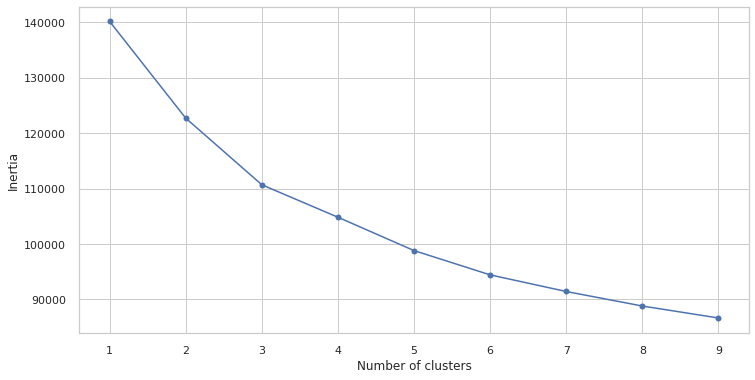

In [209]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(customers_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

After 5 clusters the the models begins to deteriorate, so we will pick 5 as optimal

#### Explained variance of the PCA

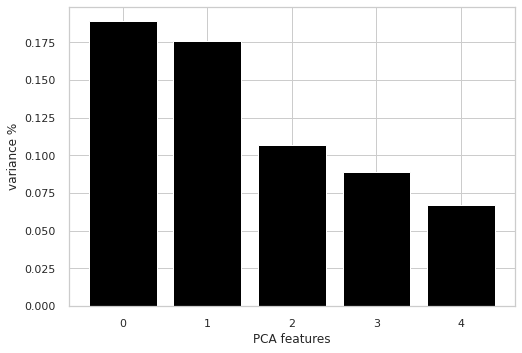

In [210]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(customers_scaled)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

The first 5 components explain 80% of the variance

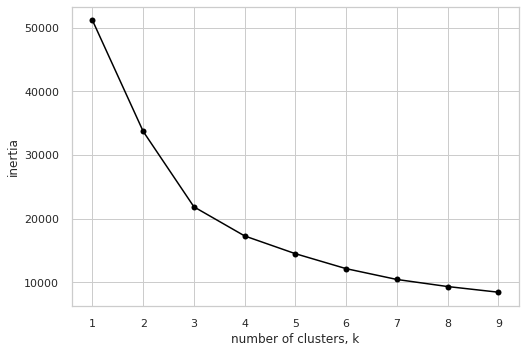

In [211]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [212]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'))

0.3285211122724981


Silhouette score is good enough

In [213]:
f=pd.read_csv('./data_for_clustering.csv')

In [214]:
f=f.drop(['customer_id'],axis=1)

#### Map back clusters to dataframe

In [215]:
pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(f)
frame['cluster'] = pred
frame.head()

,Unnamed: 0,income_high,income_low,income_low_to_mid,income_mid,income_mid_to_high,member_loyal,member_new,member_regular,BOGO,...,money_spent,money_gained,offer_completed,offer_viewed,transaction,auto_completed,gender_F,gender_M,gender_O,cluster
0,0,0,0,0,0,1,0,1,0,2,...,8.506667,0.600000,2,4,8,1,0,1,0,1
1,1,0,0,0,1,0,0,1,0,2,...,6.112308,0.615385,2,5,5,0,0,0,1,1
2,2,0,0,0,0,1,0,0,1,3,...,14.061429,0.857143,2,3,8,0,1,0,0,3
3,3,0,0,0,1,0,0,0,1,4,...,9.061765,0.764706,3,4,12,0,1,0,0,3
4,4,0,0,0,0,1,0,1,0,0,...,1.933600,0.360000,2,4,18,1,1,0,0,1


In [216]:
avg_df = f.groupby(['cluster'], as_index=False).mean()


In [217]:
customer_df=f.copy()

Rename the columns back to meaningful names

In [218]:
customer_df = customer_df.rename(columns={"gender_F": "Female",
                                          "gender_M": "Male",
                                          "gender_O": "Other"})
gender = customer_df[['Female','Male','Other']]
gender = pd.DataFrame(gender.idxmax(1))

customer_df = customer_df.rename(columns={"offer_completed": "offer completed",
                                          "offer_viewed": "offer ignored",
                                          "transaction": "casual purchase",
                                          "auto_completed": "offer auto completed"})

customer_df = customer_df.rename(columns={"income_high": "high",
                                          "income_low": "low",
                                          "income_low_to_mid": "low_to_mid",
                                          "income_mid": "mid",
                                         "income_mid_to_high": "mid_to_high"        })

customer_df = customer_df.rename(columns={"member_new": "new",                                                                       
                                          "member_regular": "regular",
                                          "member_loyal": "loyal",
                                                })
member_type=customer_df[['new','regular','loyal']]
member_type=pd.DataFrame(member_type.idxmax(1))

event = customer_df[['offer completed','offer ignored','casual purchase','offer auto completed']]
event = pd.DataFrame(event.idxmax(1))

income=customer_df[['high','low','low_to_mid','mid','mid_to_high']]
income=pd.DataFrame(income.idxmax(1))

age_group=customer_df[['adult','elderly','teenager','young-adult']]
age_group=pd.DataFrame(age_group.idxmax(1))

offer=customer_df[['BOGO','Discount','Informational']]
offer=pd.DataFrame(offer.idxmax(1))

customer_df['gender'] = gender[0]
customer_df['event'] = event[0]
customer_df['income']=income[0]
customer_df['member_type']=member_type[0]
customer_df['age_group']=age_group[0]
customer_df['offer']=offer[0]

Drop the columns that we have mapped back to the dataframe

In [219]:
customer_df.drop(columns=['high','low','low_to_mid','mid','mid_to_high','Female','Male','Other','new','regular','loyal','adult','elderly','teenager','young-adult'],axis=1,inplace=True)

In [220]:
customer_df.sample(3)

,Unnamed: 0,BOGO,Discount,Informational,time,offer_duration_days,money_spent,money_gained,offer completed,offer ignored,casual purchase,offer auto completed,cluster,gender,event,income,member_type,age_group,offer
3421,3421,4,4,4,15.107143,6.000,3.321429,0.238095,2,6,11,0,0,Female,casual purchase,low_to_mid,new,adult,BOGO
11645,11645,2,8,2,14.777778,6.500,25.943333,0.777778,5,6,20,0,2,Male,casual purchase,mid,regular,young-adult,Discount
7701,7701,3,4,1,12.516667,8.125,2.910000,0.333333,1,2,8,0,1,Male,casual purchase,mid,loyal,elderly,Discount


#### Customer distribution per predicted cluster

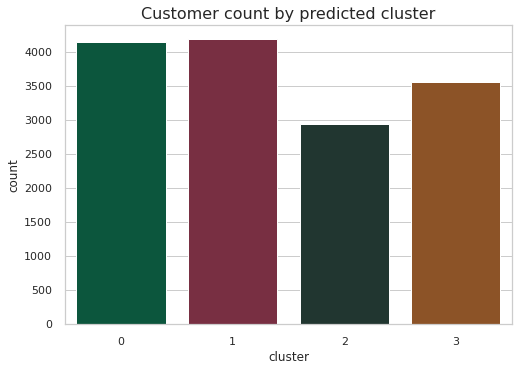

In [221]:
sns.countplot(x="cluster", data=customer_df, palette=custom_colors)
plt.title("Customer count by predicted cluster", fontsize=16)
plt.show()

There's almost an even distribution of customers among the four predicted clusters

#### Income Distribution among the predicted clusters

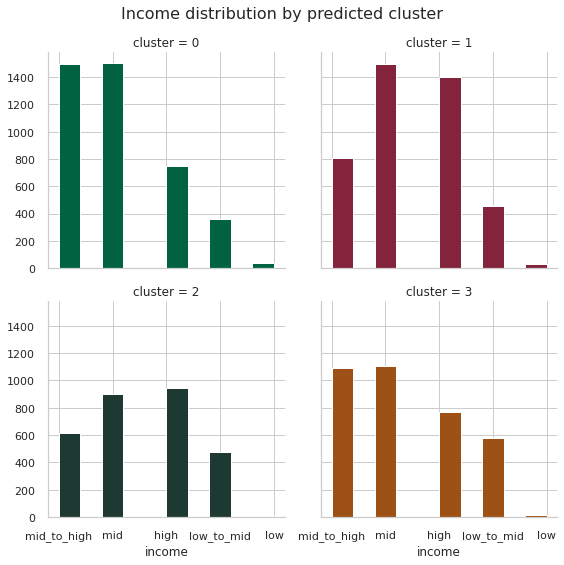

In [222]:
g = sns.FacetGrid(customer_df, col='cluster', col_wrap=2, height = 4, hue='cluster', palette=custom_colors)
g.map(plt.hist, "income")

plt.subplots_adjust(top=0.9) # fix title position
g.fig.suptitle("Income distribution by predicted cluster", fontsize=16)

plt.show()

Clusters 0 has mostly mid to high and high earners, cluster 1 has mid and high income earners.

Cluster 2 has a normal distribution from between low to mid to high income earners with mid and high income earners being the most.

Cluster 3 is mostly skewed towards high income earners

#### Age distribution per predicted cluster

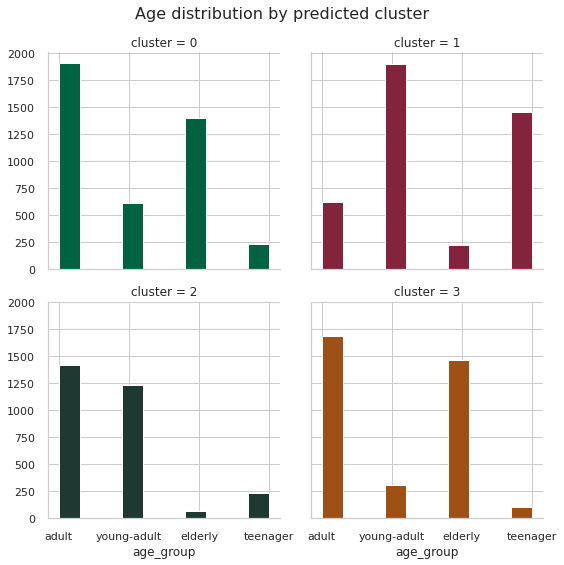

In [223]:
g = sns.FacetGrid(customer_df, col='cluster', col_wrap=2, height = 4, hue='cluster', palette=custom_colors)
g.map(plt.hist, "age_group")

plt.subplots_adjust(top=0.9) # fix title position
g.fig.suptitle("Age distribution by predicted cluster", fontsize=16)

plt.show()

Cluster 0 has a lot of elderly and young adults mostly. Cluster 2 has adults and teenagers. Cluster 3 has adults and the elderly

#### Member distribution per predicted cluster

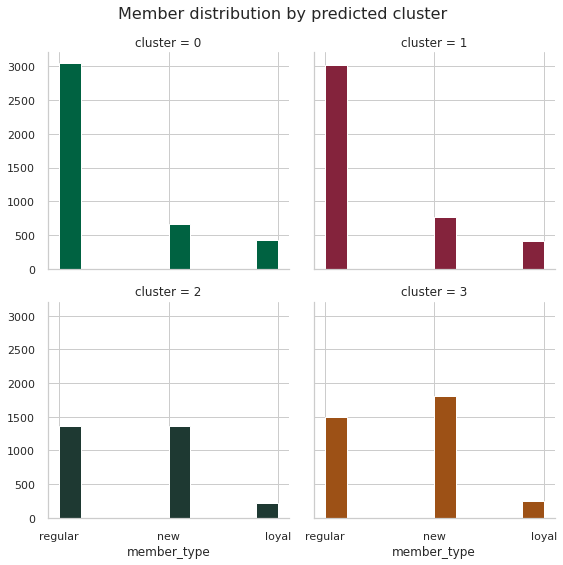

In [224]:
g = sns.FacetGrid(customer_df, col='cluster', col_wrap=2, height = 4, hue='cluster', palette=custom_colors)
g.map(plt.hist, "member_type")

plt.subplots_adjust(top=0.9) # fix title position
g.fig.suptitle("Member distribution by predicted cluster", fontsize=16)

plt.show()

Cluster 0 and 1 have mostly regular members. Cluster 2 and 3 have an almost equal distribution of regular and new members

#### Gender distribution per predicted cluster

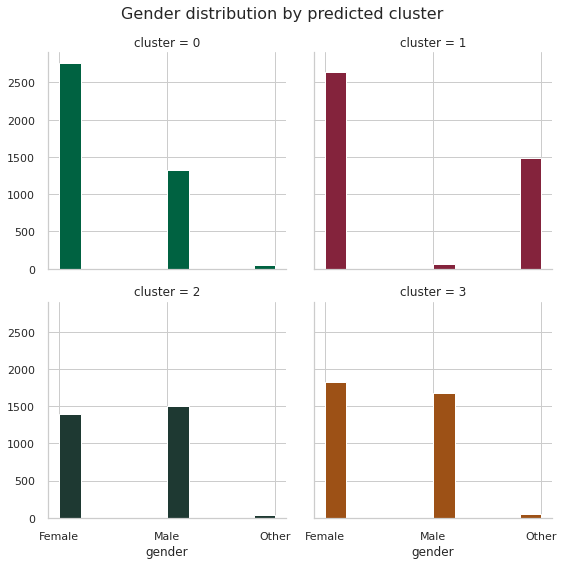

In [225]:
g = sns.FacetGrid(customer_df, col='cluster', col_wrap=2, height = 4, hue='cluster', palette=custom_colors)
g.map(plt.hist, "gender")

plt.subplots_adjust(top=0.9) # fix title position
g.fig.suptitle("Gender distribution by predicted cluster", fontsize=16)

plt.show()

#### Offer distribution per predicted cluster

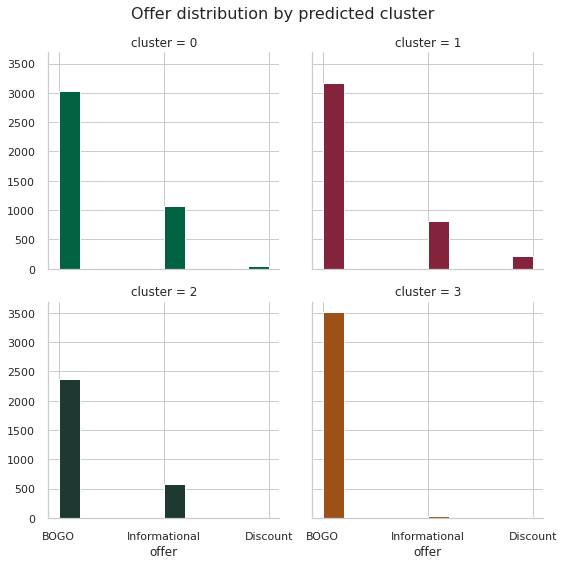

In [226]:
g = sns.FacetGrid(customer_df, col='cluster', col_wrap=2, height = 4, hue='cluster', palette=custom_colors)
g.map(plt.hist, "offer")

plt.subplots_adjust(top=0.9) # fix title position
g.fig.suptitle("Offer distribution by predicted cluster", fontsize=16)

plt.show()

#### Money spent by each predicted cluster

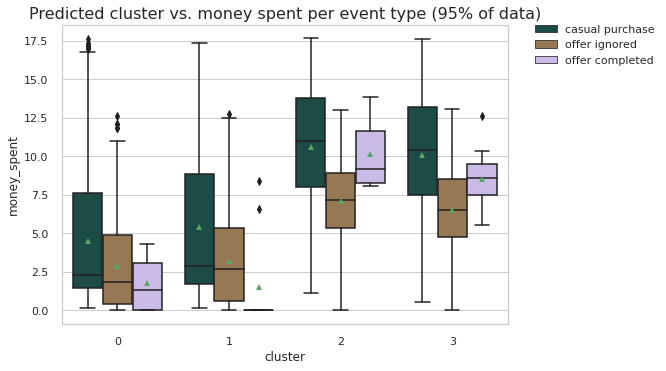

In [227]:
data = customer_df[customer_df.money_spent < customer_df.money_spent.quantile(0.95)]
sns.boxplot(x="cluster", y="money_spent", hue="event", data=data, showmeans=True, palette="cubehelix")

plt.legend(loc=(1.05,0.85))

plt.title("Predicted cluster vs. money spent per event type (95% of data)", fontsize=16)

plt.show()

Cluster 2 and 3 made the most transactions. Cluster 3 has the highest average money spent for both transactions and completed offers. Followed closely by cluster 2. Cluster 0 had a few outliers but most customers in that cluster did not complete offers, a large number of them made casual purchases and or ignored the offers.

Clusters 2 and 3 are the groups to target with offers. 

* Cluster 2 has a lot of customers in the mid and high earning bracket, has mostly adults and teenagers who are new and regular members and evenly distributed among males and females

* Cluster 3, the highest spenders, has a customers normally distributed between low to mid and high earning bracket, with mid and mid to high earners being the highest spenders in the group. In terms of member type it is evenly distributed between new and regular members with very few loyal members, same even distribution among males and females and very very few other genders. This cluster is filled with adults and the elderly which is consistent with what we have been finding

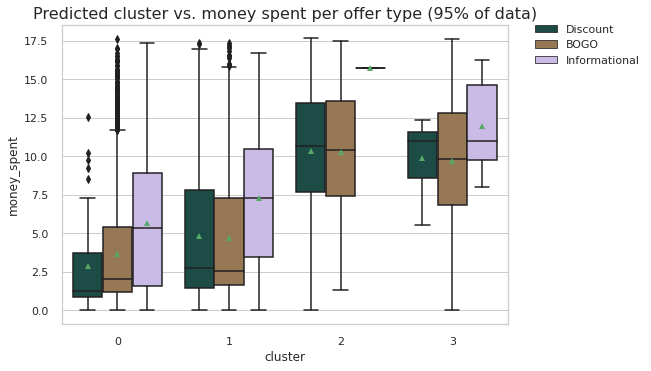

In [228]:
data = customer_df[customer_df.money_spent < customer_df.money_spent.quantile(0.95)]
sns.boxplot(x="cluster", y="money_spent", hue="offer", data=data, showmeans=True, palette="cubehelix")

plt.legend(loc=(1.05,0.85))

plt.title("Predicted cluster vs. money spent per offer type (95% of data)", fontsize=16)

plt.show()

Cluster 3 customers spent a lot on Informational offers, more than 50% of them spend above average (10USD) on it. They also spend the highest on average on Discount offers, most of them spending between 7.5 to 12.5USD. They also spent a lot on BOGO offers though not the most popular offer among this cluster. They spent a minimum of 5USD which is higher than the minimum spend for all other clusters. Most of them spent an average of 9USD on BOGO offers.

Informational offers were not popular among cluster 2 who did not spent on it. Only a few outliers completed this offer. They spent quite a lot on discount and BOGO offers spending an average of 10USD on both which was the second highest spend on offers among the clusters.

Cluster 1 liked and spent the most on informational offers spending between 2.5 and 10USD on them. They spent about the same on BOGO and Discount spending on average between 1 to 7.5USD.

Cluster O also like all 3 offers with Informational being the most popular,followed by discount and last BOGO offers. Cluster O and 1 spent the least on all offers

<a id=preprocessing><a/>

## Data Preprocessing

In [229]:
transcript_for_modelling=updated_cleaned_transcript.copy()

In [230]:
portfolio_for_modelling[:5]

,possible_reward,spent_required,offer_duration_days,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [231]:
profile_for_modelling

,gender,age,customer_id,became_member_on,income,year,quarter,days_of_membership
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,3,460
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,2,527
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,2,175
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,1,251
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,4,341
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,2,136
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,3,97
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,630
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,1,955


In [232]:
profile_for_modelling.drop(columns=['became_member_on','year','quarter'],axis=1,inplace=True)

In [233]:
df7 = pd.merge(transcript_for_modelling, profile_for_modelling, on='customer_id', how='left')

In [234]:
combined_df=pd.merge(df7, portfolio_for_modelling, on='offer_id', how='left')

In [235]:
combined_df[:5]

,Unnamed: 0,customer_id,event,time,money_spent,offer_id,money_gained,offer_completed,offer_received,offer_viewed,...,income,days_of_membership,possible_reward,spent_required,offer_duration_days,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,...,100000.0,527,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,2,e2127556f4f64592b11af22de27a7932,offer received,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,...,70000.0,175,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,5,389bc3fa690240e798340f5a15918d5c,offer received,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,...,53000.0,251,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
3,7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,0.0,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,...,51000.0,341,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
4,8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,...,57000.0,402,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0


In [236]:
columns_to_keep = ['customer_id','age','gender',
 'income','channel_social','channel_email','channel_mobile','channel_web','offer_duration_days',
'money_gained','spent_required','days_of_membership',
 'offer_type',
 'offer_received',
 'offer_viewed',
 'offer_completed']

In [237]:
model_df=combined_df[columns_to_keep]

In [238]:
%%time
improved_model_df=model_df.groupby(['customer_id','gender','income','offer_type','spent_required','money_gained'], as_index=False).sum()

CPU times: user 296 ms, sys: 28 ms, total: 324 ms
Wall time: 326 ms


In [239]:
improved_model_df

,customer_id,gender,income,offer_type,spent_required,money_gained,age,channel_social,channel_email,channel_mobile,channel_web,offer_duration_days,days_of_membership,offer_received,offer_viewed,offer_completed
0,0009655768c64bdeb2e877511632db8f,M,72000.0,bogo,5.0,0.0,33,1.0,1.0,1.0,1.0,5.0,545,1,0,0
1,0009655768c64bdeb2e877511632db8f,M,72000.0,bogo,5.0,5.0,33,1.0,1.0,1.0,1.0,5.0,545,0,1,1
2,0009655768c64bdeb2e877511632db8f,M,72000.0,discount,10.0,0.0,66,1.0,2.0,2.0,2.0,17.0,1090,2,0,0
3,0009655768c64bdeb2e877511632db8f,M,72000.0,discount,10.0,2.0,66,1.0,2.0,2.0,2.0,17.0,1090,0,1,1
4,0009655768c64bdeb2e877511632db8f,M,72000.0,informational,0.0,0.0,132,2.0,4.0,4.0,2.0,14.0,2180,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71395,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,bogo,5.0,5.0,45,0.0,1.0,1.0,1.0,7.0,692,0,1,1
71396,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,discount,10.0,0.0,180,1.0,4.0,4.0,4.0,31.0,2768,4,0,0
71397,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,discount,10.0,2.0,180,1.0,4.0,4.0,4.0,31.0,2768,0,4,4
71398,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,discount,20.0,0.0,45,0.0,1.0,0.0,1.0,10.0,692,1,0,0


In [240]:
# First, compare how many times the offer was viewed vs. received:
improved_model_df['label'] = np.where((improved_model_df['offer_viewed'] >= improved_model_df['offer_received']) &
                       (improved_model_df['offer_viewed'] > 0), "no order", "no view")

In [241]:
# Next, compare how many times offer was completed vs. viewed
# We use 0.5 threshold as in at least half of offers has to be completed:
improved_model_df['label']  = np.where(((improved_model_df['offer_completed'] / improved_model_df['offer_viewed']) >= 0.5) &
                       (improved_model_df['offer_viewed'] > 0) & 
                       (improved_model_df['offer_completed'] > 0), "possible order", "no order")

In [242]:
# Finally, if there is no order and no view:
improved_model_df['label'] = np.where((improved_model_df['offer_viewed'] == 0) & 
                       (improved_model_df['offer_completed'] == 0), "no view", improved_model_df['label'])

In [243]:
improved_model_df['label'].value_counts()

no view           31804
possible order    20080
no order          19516
Name: label, dtype: int64

In [244]:
len(improved_model_df)

71400

In [245]:
# Drop the event columns, we don't need them anymore:
improved_model_df = improved_model_df.drop(['offer_received', 'offer_viewed', 'offer_completed'], axis=1)

In [246]:
improved_model_df

,customer_id,gender,income,offer_type,spent_required,money_gained,age,channel_social,channel_email,channel_mobile,channel_web,offer_duration_days,days_of_membership,label
0,0009655768c64bdeb2e877511632db8f,M,72000.0,bogo,5.0,0.0,33,1.0,1.0,1.0,1.0,5.0,545,no view
1,0009655768c64bdeb2e877511632db8f,M,72000.0,bogo,5.0,5.0,33,1.0,1.0,1.0,1.0,5.0,545,possible order
2,0009655768c64bdeb2e877511632db8f,M,72000.0,discount,10.0,0.0,66,1.0,2.0,2.0,2.0,17.0,1090,no view
3,0009655768c64bdeb2e877511632db8f,M,72000.0,discount,10.0,2.0,66,1.0,2.0,2.0,2.0,17.0,1090,possible order
4,0009655768c64bdeb2e877511632db8f,M,72000.0,informational,0.0,0.0,132,2.0,4.0,4.0,2.0,14.0,2180,no order
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71395,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,bogo,5.0,5.0,45,0.0,1.0,1.0,1.0,7.0,692,possible order
71396,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,discount,10.0,0.0,180,1.0,4.0,4.0,4.0,31.0,2768,no view
71397,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,discount,10.0,2.0,180,1.0,4.0,4.0,4.0,31.0,2768,possible order
71398,ffff82501cea40309d5fdd7edcca4a07,F,62000.0,discount,20.0,0.0,45,0.0,1.0,0.0,1.0,10.0,692,no view


In [247]:
improved_model_df["output"] = np.where(improved_model_df['label']=='no view', 0, np.nan)


In [248]:
improved_model_df["output"] = np.where(improved_model_df['label']=='no order', 1, improved_model_df["output"])

In [249]:
improved_model_df["output"] = np.where(improved_model_df['label']=='possible order', 2, improved_model_df["output"])



In [250]:
improved_model_df.groupby(['label', 'output']).mean().index

MultiIndex([(      'no order', 1.0),
            (       'no view', 0.0),
            ('possible order', 2.0)],
           names=['label', 'output'])

In [251]:
improved_model_df.isnull().sum()

customer_id            0
gender                 0
income                 0
offer_type             0
spent_required         0
money_gained           0
age                    0
channel_social         0
channel_email          0
channel_mobile         0
channel_web            0
offer_duration_days    0
days_of_membership     0
label                  0
output                 0
dtype: int64

In [252]:

improved_model_df = improved_model_df.join(pd.get_dummies(improved_model_df['gender'])).drop('gender', axis=1) # drop the original column

for column in ['M', 'F', 'O']:
    improved_model_df = improved_model_df.rename(columns={column: ("gender_" + column.replace(" ", "_"))}) # rename new columns
    
    
improved_model_df = improved_model_df.join(pd.get_dummies(improved_model_df['offer_type'])).drop('offer_type', axis=1) # drop the original column



In [253]:
improved_model_df

,customer_id,income,spent_required,money_gained,age,channel_social,channel_email,channel_mobile,channel_web,offer_duration_days,days_of_membership,label,output,gender_F,gender_M,gender_O,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,72000.0,5.0,0.0,33,1.0,1.0,1.0,1.0,5.0,545,no view,0.0,0,1,0,1,0,0
1,0009655768c64bdeb2e877511632db8f,72000.0,5.0,5.0,33,1.0,1.0,1.0,1.0,5.0,545,possible order,2.0,0,1,0,1,0,0
2,0009655768c64bdeb2e877511632db8f,72000.0,10.0,0.0,66,1.0,2.0,2.0,2.0,17.0,1090,no view,0.0,0,1,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,72000.0,10.0,2.0,66,1.0,2.0,2.0,2.0,17.0,1090,possible order,2.0,0,1,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,72000.0,0.0,0.0,132,2.0,4.0,4.0,2.0,14.0,2180,no order,1.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71395,ffff82501cea40309d5fdd7edcca4a07,62000.0,5.0,5.0,45,0.0,1.0,1.0,1.0,7.0,692,possible order,2.0,1,0,0,1,0,0
71396,ffff82501cea40309d5fdd7edcca4a07,62000.0,10.0,0.0,180,1.0,4.0,4.0,4.0,31.0,2768,no view,0.0,1,0,0,0,1,0
71397,ffff82501cea40309d5fdd7edcca4a07,62000.0,10.0,2.0,180,1.0,4.0,4.0,4.0,31.0,2768,possible order,2.0,1,0,0,0,1,0
71398,ffff82501cea40309d5fdd7edcca4a07,62000.0,20.0,0.0,45,0.0,1.0,0.0,1.0,10.0,692,no view,0.0,1,0,0,0,1,0


In [254]:
improved_model_df = improved_model_df.drop(['customer_id', 'label'], axis=1)

In [255]:
X = improved_model_df.drop(['output'], axis=1)
y = improved_model_df['output']

In [256]:
feature_names=X.columns

In [257]:
# Split the dataset into 2/3 training and 1/3 testing sets:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)



#### Cater for class imbalance by normalizing the data

In [258]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

#### Dimensionality reduction

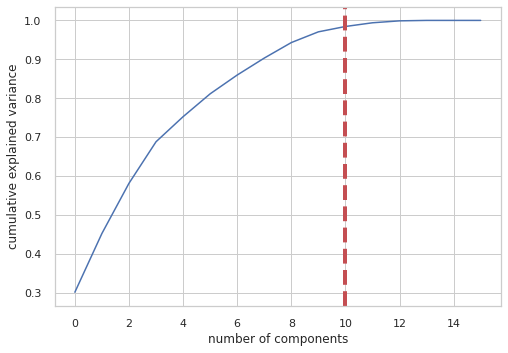

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.301023,0.301023
1,0.452145,0.151122
2,0.581108,0.128963
3,0.687933,0.106825
4,0.752388,0.064455
5,0.811185,0.058798
6,0.859530,0.048345
7,0.903105,0.043575
8,0.943013,0.039908
9,0.970594,0.027581


In [259]:
pca_test = PCA(n_components=16)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

The first 10 components explain more than 80% of the variance. So we reduce the features from 16 to 10

In [260]:
pca = PCA(n_components=10)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [261]:
feature_names

Index(['income', 'spent_required', 'money_gained', 'age', 'channel_social',
       'channel_email', 'channel_mobile', 'channel_web', 'offer_duration_days',
       'days_of_membership', 'gender_F', 'gender_M', 'gender_O', 'bogo',
       'discount', 'informational'],
      dtype='object')

Show the 10 PCA components that will be used

In [262]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
    
pca_test_df = pd.DataFrame(pca_test.components_, columns=feature_names, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
income,-0.028562,-0.036625,0.275378,0.006455,-0.158450,0.891863,-0.226312,0.089534,0.115347,-0.097069
spent_required,-0.169380,0.446360,0.073624,0.296529,-0.015432,0.029398,0.156203,0.057561,0.182167,0.566722
money_gained,-0.128817,-0.174937,0.072448,0.398101,-0.013212,0.193610,0.608934,-0.104287,-0.602865,-0.072534
age,0.392124,0.040493,0.097037,-0.001928,-0.018094,0.157566,-0.002695,0.043434,-0.110044,0.380196
channel_social,0.329502,-0.080087,0.005546,0.137463,-0.003726,-0.062453,0.227764,0.652029,0.168288,-0.262367
channel_email,0.441519,0.052701,0.026723,0.010143,0.005786,-0.001670,0.032748,0.038297,-0.083064,0.182826
channel_mobile,0.432665,-0.088407,0.007308,-0.003196,0.009227,-0.025921,-0.010107,0.114983,-0.100969,-0.203393
channel_web,0.286502,0.273583,0.052277,0.102929,0.021088,-0.033636,-0.367388,-0.445522,-0.353391,-0.257306
offer_duration_days,0.331012,0.354808,0.065766,0.176817,0.006436,-0.026223,-0.019763,0.034665,-0.066331,0.162309
days_of_membership,0.275249,0.017564,-0.000360,0.001778,-0.033827,0.094164,0.488847,-0.549413,0.578696,-0.185649


<a id=prediction><a/>
## Prediction modelling

#### Train the baseline model for Random Forest

In [263]:
%%time
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))


1.0

CPU times: user 19 s, sys: 35 ms, total: 19 s
Wall time: 19.4 s


<a id=gb><a/>
## Gradient Boosting Algorithm

<a id=tune><a/>
## Hyperparameter Tuning

#### Hyperparameter Tuning Round 1: RandomSearchCV

We will be tuning these hyperparameters:
 * n_estimators: the number of “trees” in our Random Forest.
 * max_features: the number of features at each split.
 * max_depth: the max number of “splits”each tree can have.
 * min_samples_split: the minimum number of observations required before a node of a tree can split itself.
 * min_samples_leaf: the minimum number of observations required at each leaf at the ends of each tree.
 * bootstrap: whether to use bootstrapping or not to provide data to each tree in the Random Forest. (Bootstrapping is a random sampling from the dataset with replacement.)

In [435]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']

max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]

min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=3, 
                        random_state=0)

CPU times: user 2.04 ms, sys: 0 ns, total: 2.04 ms
Wall time: 17 ms


In [437]:
%%time
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: user 1min 53s, sys: 380 ms, total: 1min 53s
Wall time: 1h 53min 42s


{'n_estimators': 500,
 'min_samples_split': 12,
 'min_samples_leaf': 18,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

With n_iter = 100 and cv = 3, we created 300 Random Forest models, randomly sampling combinations of the hyperparameters input above. We can call “best_params_” to get the best performing model’s parameters. However, “best_params_” at this stage may not give us the best insight to get a range of parameters to try for the next round of hyperparameter tuning. To get a good range of values to try next, we can easily get a dataframe of our RandomSearchCV results

In [438]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,500,12,18,sqrt,13,False,0.886116,1
1,700,12,2,sqrt,13,False,0.886053,2
2,400,23,2,sqrt,14,False,0.885593,3
3,300,28,7,log2,13,True,0.885551,4
4,700,2,2,log2,11,True,0.885530,5
5,600,50,23,sqrt,14,False,0.885321,6
6,800,28,12,sqrt,14,True,0.885154,7
7,600,23,2,sqrt,15,False,0.885091,8
8,300,2,23,log2,14,False,0.885070,9
9,300,18,18,sqrt,13,True,0.885050,10


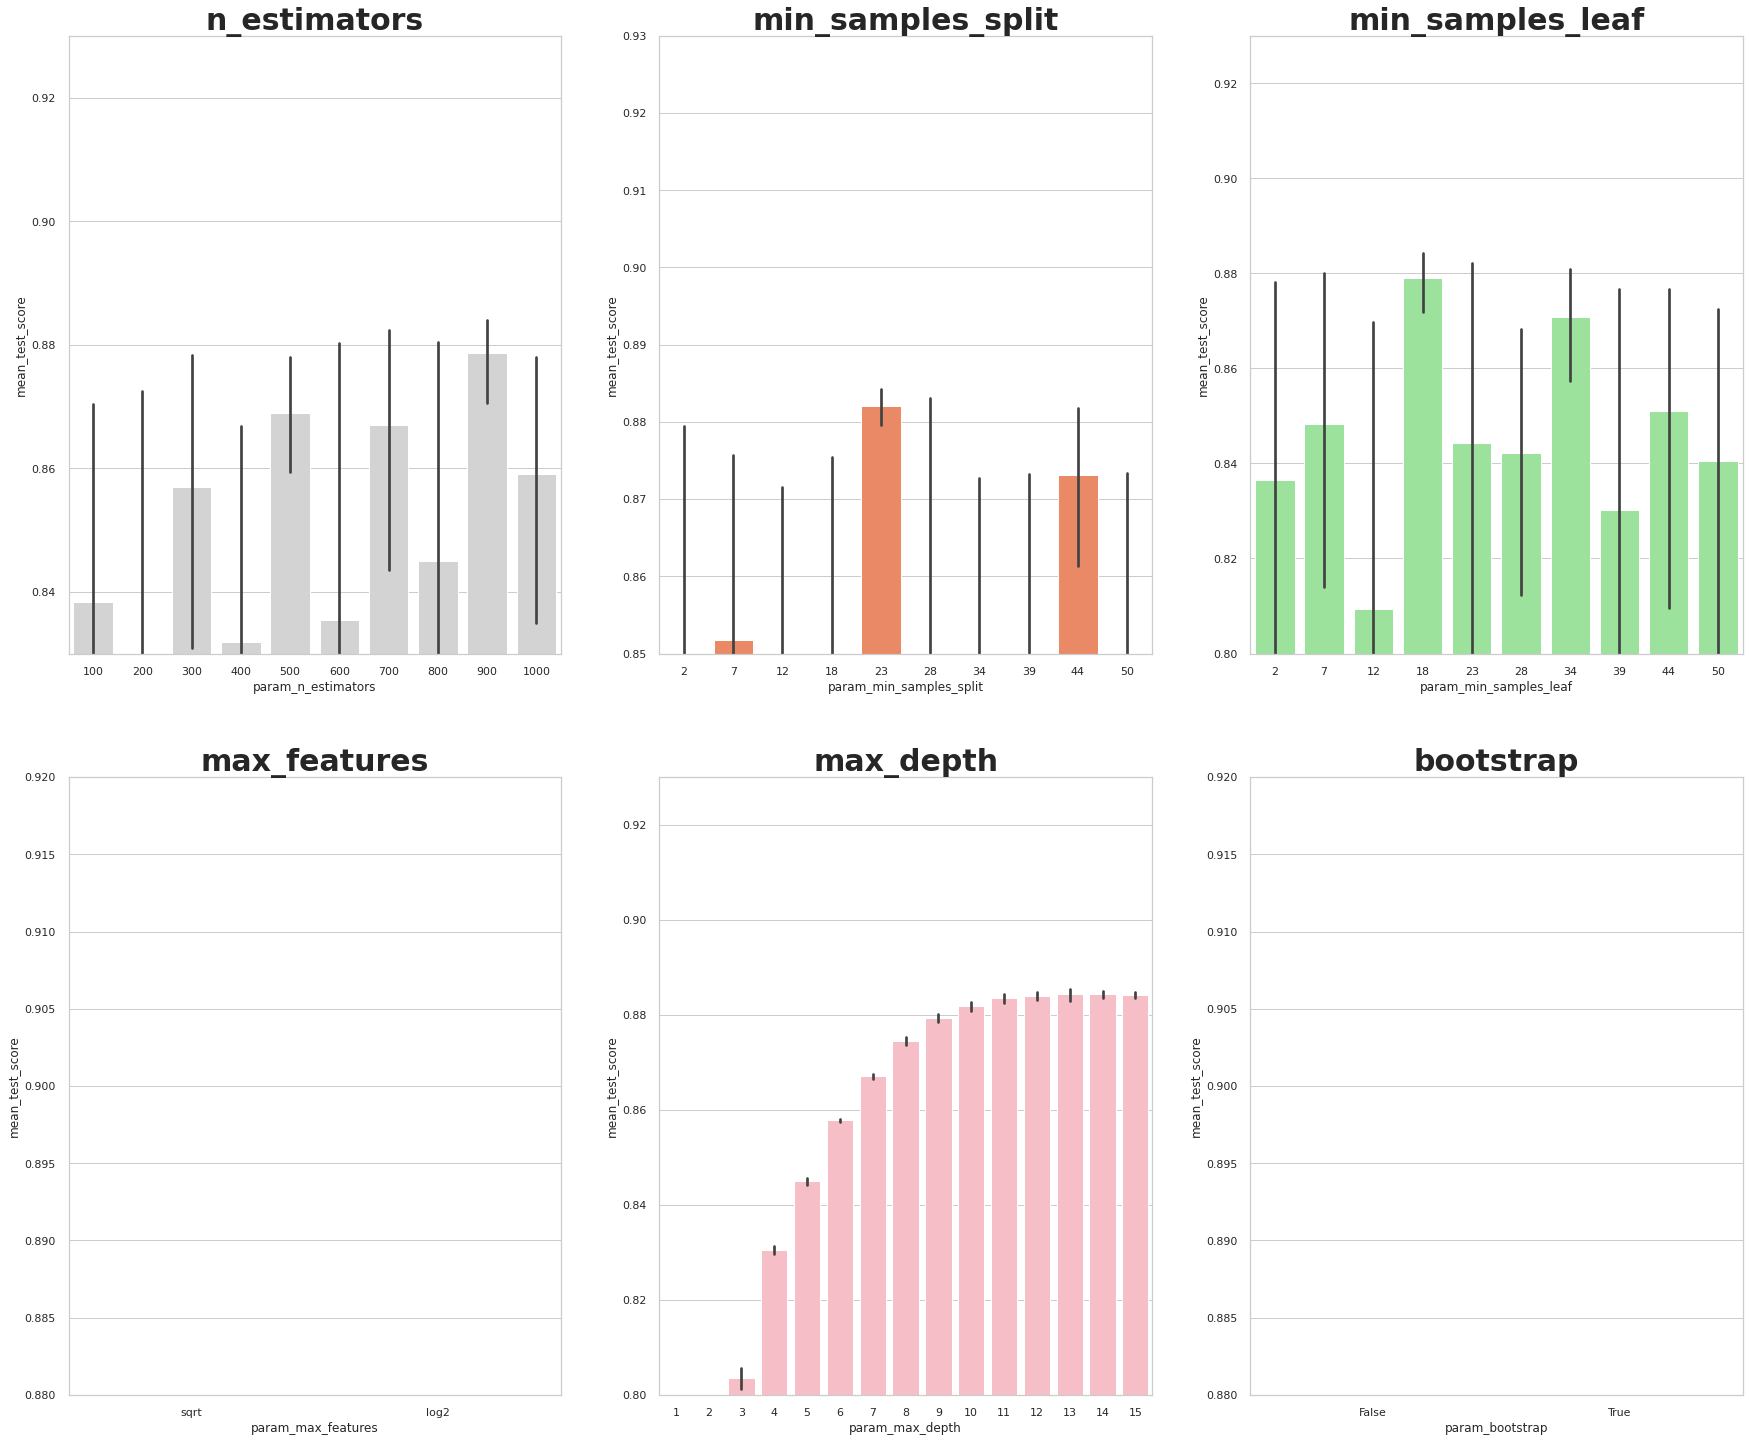

In [440]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Looking at the plots above, we can extract insights about how well each value for each hyperparameter performed on average.

n_estimators: 300, 500, 700, 900 seem to have the highest average scores.

min_samples_split:  There are  high scores at 23and 44

min_samples_leaf: We can try values between 2,7,18,34.

max_features: “sqrt” has the highest average score.

max_depth:  values of  8-15 seem to do well.

bootstrap: “False” has the highest average score.

So now we can take these insights and move into the second round of hyperparameter tuning to further narrow our selections.

#### Hyperparameter Tuning Round 2: GridSearchCV

In [441]:
%%time
## Tune this after the analysis from above
n_estimators = [500,700,900]

max_depth = [8,9,10,11,12,13,14,15]
min_samples_split = [23,44]
min_samples_leaf = [2,18,34]

param_grid = {'n_estimators': n_estimators,
               
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=3)
gs.fit(X_train_scaled_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
CPU times: user 2min 10s, sys: 587 ms, total: 2min 10s
Wall time: 3h 38min 32s


{'max_depth': 13,
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 900}

In [267]:
x_test_scaled_df=pd.DataFrame(X_test_scaled,columns=feature_names)

In [268]:
x_test_scaled_df

,income,spent_required,money_gained,age,channel_social,channel_email,channel_mobile,channel_web,offer_duration_days,days_of_membership,gender_F,gender_M,gender_O,bogo,discount,informational
0,0.480289,0.308519,-0.570975,0.836877,0.872210,0.326346,0.421475,-1.453699,0.498934,-0.250415,1.150423,-1.117482,-0.120439,1.197087,-0.92360,-0.384232
1,-0.303513,-1.582487,-0.570975,-0.785519,-1.026961,-0.700134,-0.493049,-0.360391,-1.112714,-0.571356,1.150423,-1.117482,-0.120439,-0.835361,-0.92360,2.602591
2,-0.026877,-0.258783,-0.570975,-0.576696,0.872210,0.326346,0.421475,0.732917,0.498934,1.569288,1.150423,-1.117482,-0.120439,-0.835361,1.08272,-0.384232
3,0.618607,0.308519,2.948957,-0.062669,-0.077375,-0.700134,-0.493049,-1.453699,-0.629219,-0.218217,1.150423,-1.117482,-0.120439,1.197087,-0.92360,-0.384232
4,-0.441831,2.199524,1.188991,-0.383936,-1.026961,-0.700134,-1.407573,-0.360391,-0.145725,-0.563047,1.150423,-1.117482,-0.120439,-0.835361,1.08272,-0.384232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23557,0.295865,0.308519,0.133011,-0.303619,-0.077375,-0.700134,-0.493049,-0.360391,-0.145725,-0.390632,-0.869245,0.894869,-0.120439,-0.835361,1.08272,-0.384232
23558,2.416740,0.308519,-0.570975,0.997511,0.872210,0.326346,0.421475,0.732917,-0.145725,-0.451912,1.150423,-1.117482,-0.120439,1.197087,-0.92360,-0.384232
23559,-0.580149,-0.258783,0.485004,-0.753392,-0.077375,-0.700134,-0.493049,-0.360391,-0.629219,0.571152,-0.869245,0.894869,-0.120439,-0.835361,1.08272,-0.384232
23560,0.203653,0.308519,0.133011,0.451357,0.872210,1.352827,1.335999,1.826225,2.594077,2.261024,1.150423,-1.117482,-0.120439,-0.835361,1.08272,-0.384232


In [269]:
x_test_scaled_df.drop(columns=['bogo','discount','informational','gender_M','gender_F','gender_O'],axis=1,inplace=True)

## Evaluate Performance Of Models On Test Data

Now, we can evaluate each of the models that we have made on our test data. Remember that we are testing 3 models:

    1. Baseline Random Forest
    2. Baseline Random Forest With PCA Reduced Dimensionality
    3. Baseline Random Forest With PCA Reduced Dimensionality & Hyperparameter Tuning

In [469]:
y_pred = rfc.predict(x_test_scaled_df)
y_pred_pca = rfc.predict(X_test_scaled_pca)
y_pred_gs = gs.best_estimator_.predict(X_test_scaled_pca)

In [486]:
from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1','actual 2'], columns = ['predicted 0', 'predicted 1','predicted 2'])
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1','actual 2'], columns = ['predicted 0', 'predicted 1','predicted 2'])
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1','actual 2'], columns = ['predicted 0', 'predicted 1','predicted 2'])
display(conf_matrix_baseline)

display('Baseline Random Forest recall score', recall_score(y_test, y_pred, average='weighted'))
display(conf_matrix_baseline_pca)

display('Baseline Random Forest With PCA recall score', recall_score(y_test, y_pred_pca,average='weighted'))
display(conf_matrix_tuned_pca)

display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score', recall_score(y_test, y_pred_gs,average='weighted'))

,predicted 0,predicted 1,predicted 2
actual 0,8226,1303,1007
actual 1,1966,610,3840
actual 2,5044,855,711


'Baseline Random Forest recall score'

0.4051863169510228

,predicted 0,predicted 1,predicted 2
actual 0,8724,1040,772
actual 1,643,5773,0
actual 2,395,12,6203


'Baseline Random Forest With PCA recall score'

0.878533231474408

,predicted 0,predicted 1,predicted 2
actual 0,8644,1000,892
actual 1,541,5874,1
actual 2,204,29,6377


'Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score'

0.8868092691622104

From this our result, our best perfoming model is our hyper parameter tund Random Forest model

In [487]:
def evaluate_model_performance(clf, X_train, y_train):
    '''Prints a model's accuracy and F1-score
    INPUT:
    clf - Model object
    X_train - Training data matrix
    y_train - Expected model output vector

    OUTPUT:
    clf_accuracy: Model accuracy
    clf_f1_score: Model F1-score
    '''
    
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf,average='weighted')
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [490]:
# Evaluate random forest classifier model's performance
evaluate_model_performance(gs.best_estimator_, X_train_scaled_pca, y_train)

RandomForestClassifier model accuracy: 0.916
RandomForestClassifier model f1-score: 0.915


(0.9159454826706802, 0.9153190471092886)

### Feature importance

Text(0.5, 1.0, 'Estimated Feature Importance Based on Random Forest')

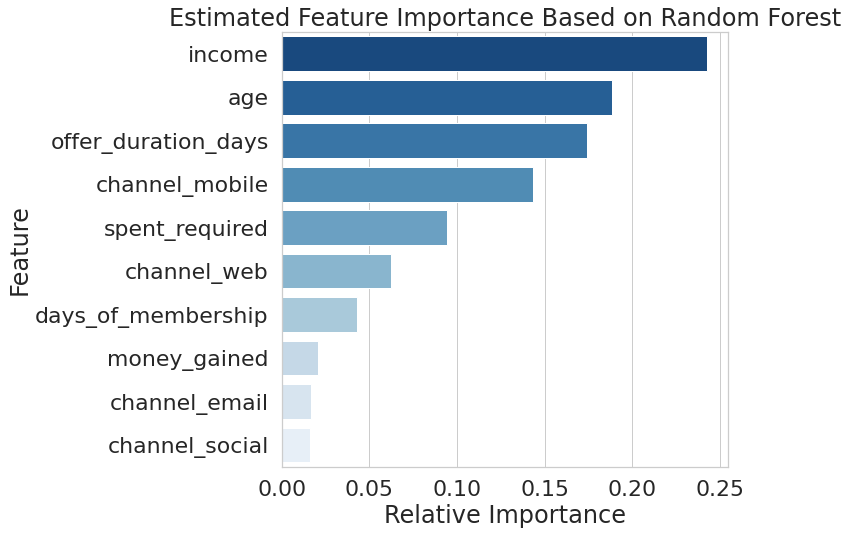

In [491]:
# Define variables
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
relative_importance = gs.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(feature_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

# Plot Estimated Feature Importance
plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Estimated Feature Importance Based on Random Forest')

In [456]:
feature_importance.head(n=10)

,feature,relativeimportance
0,income,0.242512
1,age,0.188434
2,offer_duration_days,0.174120
3,channel_mobile,0.143021
4,spent_required,0.093982
5,channel_web,0.062092
6,days_of_membership,0.042789
7,money_gained,0.020546
8,channel_email,0.016501
9,channel_social,0.016003


According to our model, the 10 most important features that determine whether a customer will ignore, make an order or not make an order are:
* Income which contributes the most- 24%
* Age which contributes-18%
* Duration of offer-17%
* Offer sent on mobile-14%
* The spend required to complete the offer-9%
* If offer was sent on web-6%
* How long a customer has been a member-4%
* The reward to be gained-2%
* Offer sent via email-1.6%
* Offer sent via social media-1.6%

> Which means demographics contribute 42% of the decision. The channel used to communicate the offer contributes 23.2%. The details of the offer contribute 11%. How long the customer has been a member contributes 4%.

Print the best model's hyperparameters

In [492]:
print(gs.best_estimator_)

RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=23,
                       n_estimators=900)


In [493]:
from sklearn.metrics import classification_report

labels = ["no view", "no order", "possible order"]
print(classification_report(y_test,y_pred, target_names=labels))

                precision    recall  f1-score   support

       no view       0.54      0.78      0.64     10536
      no order       0.22      0.10      0.13      6416
possible order       0.13      0.11      0.12      6610

      accuracy                           0.41     23562
     macro avg       0.30      0.33      0.30     23562
  weighted avg       0.34      0.41      0.35     23562



In [264]:
rf=RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=23,
                       n_estimators=900)

In [265]:
%%time
rf.fit(X_train_scaled_pca, y_train)
display(rf.score(X_train_scaled_pca, y_train))


0.9167398302604624

CPU times: user 2min 20s, sys: 69.6 ms, total: 2min 20s
Wall time: 2min 21s


In [270]:
%%time
y_pred_test = rf.predict(x_test_scaled_df)

CPU times: user 2.93 s, sys: 0 ns, total: 2.93 s
Wall time: 2.95 s


<a id=conclusion><a/>
## Conclusion

### Test on new data

In [277]:
prediction=y_pred_test
frames=x_test_scaled_df
frames['Prediction'] = prediction
frames.head()

,income,spent_required,money_gained,age,channel_social,channel_email,channel_mobile,channel_web,offer_duration_days,days_of_membership,Prediction
0,0.480289,0.308519,-0.570975,0.836877,0.872210,0.326346,0.421475,-1.453699,0.498934,-0.250415,0.0
1,-0.303513,-1.582487,-0.570975,-0.785519,-1.026961,-0.700134,-0.493049,-0.360391,-1.112714,-0.571356,0.0
2,-0.026877,-0.258783,-0.570975,-0.576696,0.872210,0.326346,0.421475,0.732917,0.498934,1.569288,0.0
3,0.618607,0.308519,2.948957,-0.062669,-0.077375,-0.700134,-0.493049,-1.453699,-0.629219,-0.218217,0.0
4,-0.441831,2.199524,1.188991,-0.383936,-1.026961,-0.700134,-1.407573,-0.360391,-0.145725,-0.563047,0.0


In [297]:
frames['Prediction'] = frames['Prediction'].map({0: 'no view', 1: 'no order', 2: 'possible order'})

In [308]:
frames.Prediction.value_counts()

no view           12565
possible order     6387
no order           4610
Name: Prediction, dtype: int64

In [324]:
frames.head()

,income,spent_required,money_gained,age,channel_social,channel_email,channel_mobile,channel_web,offer_duration_days,days_of_membership,Prediction
0,0.480289,0.308519,-0.570975,0.836877,0.872210,0.326346,0.421475,-1.453699,0.498934,-0.250415,no view
1,-0.303513,-1.582487,-0.570975,-0.785519,-1.026961,-0.700134,-0.493049,-0.360391,-1.112714,-0.571356,no view
2,-0.026877,-0.258783,-0.570975,-0.576696,0.872210,0.326346,0.421475,0.732917,0.498934,1.569288,no view
3,0.618607,0.308519,2.948957,-0.062669,-0.077375,-0.700134,-0.493049,-1.453699,-0.629219,-0.218217,no view
4,-0.441831,2.199524,1.188991,-0.383936,-1.026961,-0.700134,-1.407573,-0.360391,-0.145725,-0.563047,no view


<AxesSubplot:xlabel='Prediction', ylabel='count'>

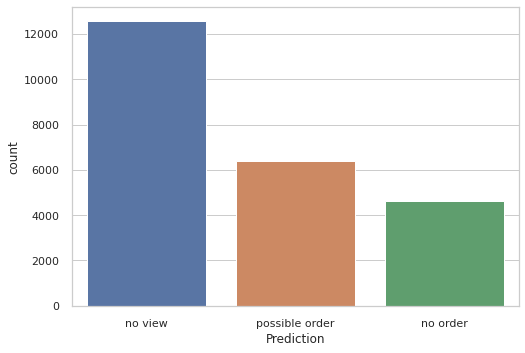

In [325]:
sns.countplot(frames['Prediction'])

<a id=results><a/>
## Summary of Key Findings

**Starbucks Customer Demographics**:

58.6 % of customers are male, 39.8% are female and 1.4% prefer not to specify gender. While men are the largest population, females are the highest earners and spenders. Most men are in the low_to_mid and mid income bracket.

There's an almost equal distribution of male and females among the mid to high income bracket. Middle income and low_to_mid income earners occupy a huge proportion of the population, with mid income earners being the dorminant. Low earners are fewer, they are the least.

**Starbucks Customer spending behavior**:

Females are the highest spenders, they spend on average 0.23USD per day followed by gender O who spend 0.21USD per day and least spenders are males who spent on average 0.16USD. 

The elderly, that is those above 60 are the highest age group spending an average of 0.21USD per day. Adults, those aged 35-60 are the second highest spenders on average, spending 0.19USD per day. Ages 17-34 are the least spenders, spending roughly 0.14USD per day

As expected, high income earners have the highest average spend. Spending on average, 0.28USD per day, mid to high earners also spend highly with 0.23USD per day. Low and low to mid income earners spend right around the same amount. They spend about 0.11US per day

New members have the highest average daily spend followed by regular members. Loyal members, those who have been members for over 3 years are no longer daily spenders

Summary of average daily spending has revealed that:
* High earning elderly females who are new members have the highest daily average spend i.e Female members who are over 60 years earning over 90K and have been members for at least 1200 days

**Starbucks Offers**:
* 41 395 new customers received offers. Of those that received offers, only 41.5% viewed the offer and did not complete it and 37.5% completed the offer.

* 40 539 new customers made transactions on the app, new members made the highest number of transactions of all the members. Regular members also made a sizeable amount of transactions on the app, they made 30 036 transactions. Loyal members had the least number of transactions, making 12 299 transactions

* Regular members were the second highest to receive offers, receiving 19 223 offers but only 24% viewing the offers and 60% completing the offers. Most regular members completed the offers without viewing them.

* 5785 loyal customers received offers, of this number, 38.2% viewed the offers and 41% completed the offers.

**Perfomance of Offers on different members**:
* On new customers:

    * 39.88% of new customers received BOGO offer, 41.4% of those that received the BOGO viewed it, which constituted 39.8% of all offer views by new customers. 45% of those new customers that received the BOGO completed it, accounting for 48.8% of all new customers that completed offers.

    * 40% of new customers received the discount offer, 27.5% of those that received this offer viewed the offer, accounting for 26.6% of all offer views by new customers. 47.8% of new customers who received the discount offer completed it, which accounts for 51.1% of all offers completed by new customers.

     * 20% of new customers received informational offers, 69.5% of them viewed it, which accounts for 33.5% of views by new customers.

* On regular customers:

     * 39.77% of regular customers received the BOGO offer, of these only 18% viewed it. This means that 29.4% of all views of BOGO offer were done by regular customers. 74% of regular customers who received the BOGO offer completed it. This accounts for 48.6% of all offers completed by regular customers

     * 40.3% of regular customers received the discount offer, of these only 7% of them viewed it. This means that 12.1% of offer views by regular customers were viewing discount offer. 77.1% of regular customers who received discount offer completed it. This means 51.4% of all offers completed by regular customers was on discount offers.

    * 19.91% of regular customers received the informational offer, of these 71.6% of them viewed it. 23.5% of all views made by regular customers were on informational offers.

* On loyal customers:

    * 40.3% of loyal customers received the BOGO offer, of these 46% of them viewed it. This means that, 48.85% of all loyal customer views were on BOGO. 40.5% of loyal customers who received BOGO completed it. This accounts for 39.86% of all offers completed by loyal customers.

    * 39.6% of loyal customers received discount offer, 13.2% viewed it. This means that 13.7% of all views by loyal customers was on discount offer.62.28% of loyal customers who received the discount offer completed it. This accounts for 60% of all offers completed by loyal customers.

    * The bogo_3 is the most succesful offer with 29% success. The discount offers perfomed pretty well averaging 27%.

**Pefomance of Offers on different Genders**:
* Female BOGO offer:

    * 10 975 females received the BOGO offers, 1368 viewed it but did not complete it. 7566 received and completed it. Only 995 of them auto completed it.

* Female Discount offer:

    * 10 943 females received the Discount offers, 1267 viewed but did not complete. 6369 received and completed it.1360 of them auto completed it.

* Female Informational offer:

    * 5538 females received the informational offer, 1242 viewed but did not complete the offer. 2668 received and completed the offer.

* Male BOGO offer:

    * 15 208 males received the BOGO offer. Of these 2534 viewed the offer but did not complete it. 9785 received and completed the offer. 963 completed the offer automatically.

* Male Discount offer:

    * 15 354 males received the discount offer. Of these 2201 males only viewed the offer. 8049 received and completed the offer. 1271 auto completed the offer

* Male Informational offer:

    * 7567 males received the informational offer. 1480 males viewed the offer without completing it. 3809 received and completed it

* Gender unspecified BOGO offer:

    * 354 of these customers received the offer. 56 only viewed the offer. 253 received and completed the offer while 20 auto completed it.

    * Mid income earners received and completed the most offers and made the most transactions.

    * Low to mid income earners were the second highest in terms of offers received and completed.


**Customer Clusters**
There are 4 types clusters/Segments of customers.
* **Cluster 0**:
    * Clusters 0 has mostly mid to high and high earners and has mostly elderly and young adults. This cluster liked and responded to all three offers though they spent the least of all 4 clusters. Cluster 0 had a few outliers but most customers in that cluster did not complete offers, a large number of them made casual purchases and or ignored the offers. Cluster O also like all 3 offers with Informational being the most popular,followed by discount and last BOGO offers

* **Cluster 1**:
    * This cluster has mostly mid to high income earners. Cluster 1 liked and spent the most on informational offers spending between 2.5 and 10 USD on them. They spent about the same on BOGO and Discount spending on average between 1 to 7.5 USD. In general, this cluster spent the least amount on all offers.

* **Cluster 2**:
    * Cluster 2 made the highest transactions. Cluster 2 has a normal distribution from between low to mid to high income earners with most members in the higher income bracket. Cluster 2 has mostly new and regular members. The prevalent ages being adults and teenagers with an even distribution among males and females. Informational offers were not popular among cluster 2, they did not spent on it. Only a few outliers completed this offer. They spent quite a lot on discount and BOGO offers spending an average of 10USD on both which was the second highest spend on offers among the clusters.

* **Cluster 3**:
    * Cluster 3 is mostly skewed towards high income earners. Cluster 3 has the highest average money spent for both transactions and completed offers. Followed closely by cluster 2. In terms of member type it is evenly distributed between new and regular members with very few loyal members, same even distribution among males and females and very very few other genders. This cluster is filled with adults and the elderly which is consistent with what we have been finding. Cluster 3 customers spent a lot on Informational offers, more than 50% of them spend above average (10USD) on it. They also spend the highest on average on Discount offers, most of them spending between 7.5 to 12.5USD. They also spent a lot on BOGO offers though not the most popular offer among this cluster. They spent a minimum of 5USD which is higher than the minimum spend for all other clusters. Most of them spent an average of 9USD on BOGO offers.



### Findings  from the model

According to our model, the 10 most important features that determine whether a customer will ignore, make an order or not make an order are:
* Income which contributes the most- 24%
* Age which contributes-18%
* Duration of offer-17%
* Offer sent on mobile-14%
* The spend required to complete the offer-9%
* If offer was sent on web-6%
* How long a customer has been a member-4%
* The reward to be gained-2%
* Offer sent via email-1.6%
* Offer sent via social media-1.6%

> Which means demographics contribute 42% of the decision. The channel used to communicate the offer contributes 23.2%. The details of the offer contribute 11%. How long the customer has been a member contributes 4%.

<a id=recs><a/>
## Recommendations

**Offers**:
BOGO and Discount offers perfomed very well accross all demographics and had a lot of money spent on them. Starbucks should keep rolling these out. Informational offers did not perform very well and are also difficult to monitor.There is also no way to track whether informational offers are redeemed (can only see if user received or opened informational offer). We have to assume they were influenced by the informational offer if they viewed it. Offer duration is also very significant factor in whether customers respond to offers, it contributes 17% to the decision of completing and not completing an offer. More money was spent for offers that lasted longer, on average 2USD more was spent on offers that lasted more than 5 days and more. The spent required is also a good measure, generally customers will spend at most under 7 dollars for spent required above 7.

**Target Groups**:
Females on average spend the most on all offers. Adult and elderly women who are mid to high earners are the most profitable group. They respond to offers and spend a lot on them.

In general, the higher the income the more customers spend on offers.

Adults and the elderly on average spend more on offers than all other groups.

42% of the decision to complete an offer or not is influenced by demographics i.e age and income. 

Clusters 2 and 3 should be targeted more because they are high spenders, they are newer members, adults and have good income.

**Channel of sending offers**:
Channels sent via mobile received the highest spend and were the most completed. Most people who received offer via mobile completed it. It seems that mobile is the most important channel. According to the model, receiving the offer via mobile contributes 14% to the response on the offer. Probably because the rewards app is a mobile app. Other media do contribute like the web (6%), other channels contribute 1.6% each. 

**Model**:
Starbucks should use the random forest classifier model, it can handle large amount of training data and is good for the multiclassification problem. By tuning it using random search and grid search, its best parameters can be found.